<a href="https://colab.research.google.com/github/Laura9704/Fundamentos_MCD/blob/main/Codigo_taller.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

pd.set_option('display.max_columns', None)

import matplotlib.pyplot as plt #gráficos
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from math import sqrt

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler
import random
import os

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"svlauracarolinasv","key":"1a25d5152ddda23f3fa3ff67c08a105c"}'}

In [ ]:
import sys
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
if torch.cuda.is_available():
    print("Utilizamos la primera GPU disponible")
    DEVICE=device = torch.device('cuda:0')
    os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
else:
    print("No hay GPU, toca correr todo en CPU")
    DEVICE=device = torch.device('cpu')

DEVICE

No hay GPU, toca correr todo en CPU


device(type='cpu')

In [ ]:
os.environ["CUDA_LAUNCH_BLOCKING"] = "1" if torch.cuda.is_available() else "0"

In [ ]:
def reset_seed():
    SEED = 42
    torch.backends.cudnn.enabled = True
    torch.manual_seed(SEED)
    np.random.seed(SEED)
    random.seed(SEED)

    if torch.cuda.is_available():
        torch.cuda.manual_seed(SEED)
        torch.cuda.manual_seed_all(SEED)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

In [ ]:
reset_seed()

# Cargamos los datos

In [ ]:
import zipfile

# --- PASO 0: Instalar librerías para archivos Parquet ---
# Pyarrow es la librería más común y estable para leer Parquet con Pandas.
print("0. Instalando librería 'pyarrow' para leer archivos Parquet...")
!pip install pyarrow --quiet
print("Instalación completada.\n")


# --- PASO 1: Descargar y Descomprimir ---
competition_name = 'fa-ii-2025-ii-pronosticos-nn-rnn-lstm-tcn'
zip_file_name = f'{competition_name}.zip'

print(f"1. Descargando datos de la competición: {competition_name}...")
# El comando !kaggle descarga el archivo ZIP. El flag -p /content/ lo coloca en la raíz.
!kaggle competitions download -c {competition_name} -p /content/

# Descomprimir el archivo ZIP
print(f"2. Descomprimiendo archivos...")
try:
    with zipfile.ZipFile(zip_file_name, 'r') as zip_ref:
        # Extraer todo el contenido a la carpeta actual (/content/)
        zip_ref.extractall('/content/')
    print("Descompresión completada. Archivos Parquet listos.")
except FileNotFoundError:
    print(f"\n[ERROR] No se encontró el archivo ZIP: {zip_file_name}")
    print("Asegúrate de que la descarga fue exitosa.")
    exit()

# --- PASO 2: Cargar df_train y df_test usando pd.read_parquet ---
try:
    # Cargar el set de entrenamiento
    df_train = pd.read_parquet('df_train.parquet')
    print(f"\n3. df_train cargado (Parquet). Shape: {df_train.shape}")

    # Cargar el set de prueba (test)
    df_test = pd.read_parquet('df_test.parquet')
    print(f"   df_test cargado (Parquet). Shape: {df_test.shape}")

    # Verificar las primeras filas
    print("\nPrimeras filas del df_train:")
    print(df_train.head())

except Exception as e:
    print("\n[ERROR] No se pudieron cargar 'df_train.parquet' o 'df_test.parquet'.")
    print(f"Detalle del error: {e}")

0. Instalando librería 'pyarrow' para leer archivos Parquet...
Instalación completada.

1. Descargando datos de la competición: fa-ii-2025-ii-pronosticos-nn-rnn-lstm-tcn...
  0% 0.00/163k [00:00<?, ?B/s]
100% 163k/163k [00:00<00:00, 470MB/s]
2. Descomprimiendo archivos...
Descompresión completada. Archivos Parquet listos.

3. df_train cargado (Parquet). Shape: (8932, 10)
   df_test cargado (Parquet). Shape: (184, 9)

Primeras filas del df_train:
        date  min_temp  avg_temp  max_temp  min_rel_humidity  \
0 2000-01-01      20.1      23.1      27.5              57.0   
1 2000-01-02      19.2      22.0      26.7              58.0   
2 2000-01-03      18.0      21.7      28.8              51.0   
3 2000-01-04      17.8      21.9      27.1              50.0   
4 2000-01-05      19.0      22.3      27.4              51.0   

   avg_rel_humidity  max_rel_humidity  solar_radiation  evapotranspiration  \
0              77.0              95.0            308.1                 2.8   
1        

In [ ]:
df=df_train.copy()

In [ ]:
print(df_train.shape)
df_train.head(5)

(8932, 10)


date  min_temp  avg_temp  max_temp  min_rel_humidity  \
0 2000-01-01      20.1      23.1      27.5              57.0   
1 2000-01-02      19.2      22.0      26.7              58.0   
2 2000-01-03      18.0      21.7      28.8              51.0   
3 2000-01-04      17.8      21.9      27.1              50.0   
4 2000-01-05      19.0      22.3      27.4              51.0   

   avg_rel_humidity  max_rel_humidity  solar_radiation  evapotranspiration  \
0              77.0              95.0            308.1                 2.8   
1              82.0              98.0            343.1                 4.1   
2              80.0              98.0            456.1                 4.5   
3              74.0              90.0            391.5                 3.8   
4              76.0              95.0            348.4                 3.9   

   precipitation  
0            0.0  
1            0.0  
2            2.1  
3            0.0  
4            0.0

In [ ]:
df_train.tail(5)

date  min_temp  avg_temp  max_temp  min_rel_humidity  \
8927 2024-06-26      19.5      23.0      29.1              58.0   
8928 2024-06-27      20.2      22.0      27.9              66.0   
8929 2024-06-28      18.8      22.7      28.4              59.0   
8930 2024-06-29      20.2      24.4      31.0              51.0   
8931 2024-06-30      19.5      22.8      28.9              59.0   

      avg_rel_humidity  max_rel_humidity  solar_radiation  evapotranspiration  \
8927              87.0             100.0            358.8                 2.9   
8928              92.0             100.0            276.0                 2.2   
8929              88.0             100.0            379.5                 3.1   
8930              81.0             100.0            547.2                 4.6   
8931              87.0             100.0            324.7                 2.6   

      precipitation  
8927            0.0  
8928            0.9  
8929            1.9  
8930            0.0  
8931            0.0

# Explorando los datos

In [ ]:
df.describe()

date     min_temp     avg_temp     max_temp  \
count                           8932  8876.000000  8875.000000  8878.000000   
mean   2012-04-04 01:58:20.044782848    19.177129    23.299763    29.580897   
min              2000-01-01 00:00:00    12.500000    19.400000    21.200000   
25%              2006-02-20 18:00:00    18.600000    22.500000    28.500000   
50%              2012-04-07 12:00:00    19.200000    23.300000    29.700000   
75%              2018-05-20 06:00:00    19.900000    24.100000    30.800000   
max              2024-06-30 00:00:00    23.100000    27.400000    35.700000   
std                              NaN     1.076388     1.131674     1.925048   

       min_rel_humidity  avg_rel_humidity  max_rel_humidity  solar_radiation  \
count       8838.000000       8840.000000       8881.000000      8844.000000   
mean          49.783775         79.919796         97.412003       396.537427   
min           17.000000         50.000000         77.000000        57.900000   
25%           44.000000         75.000000         96.000000       332.775000   
50%           50.000000         80.000000         99.000000       398.200000   
75%           56.000000         85.000000        100.000000       466.000000   
max           87.000000         97.000000        100.000000       654.400000   
std            9.344220          7.012475          3.570296        96.418008   

       evapotranspiration  precipitation  
count         7932.000000    8932.000000  
mean             5.993633       3.246731  
min              0.000000       0.000000  
25%              2.700000       0.000000  
50%              3.800000       0.000000  
75%              4.500000       1.600000  
max           6999.000000     101.800000  
std            136.046619       8.519706

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8932 entries, 0 to 8931
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   date                8932 non-null   datetime64[ns]
 1   min_temp            8876 non-null   float64       
 2   avg_temp            8875 non-null   float64       
 3   max_temp            8878 non-null   float64       
 4   min_rel_humidity    8838 non-null   float64       
 5   avg_rel_humidity    8840 non-null   float64       
 6   max_rel_humidity    8881 non-null   float64       
 7   solar_radiation     8844 non-null   float64       
 8   evapotranspiration  7932 non-null   float64       
 9   precipitation       8932 non-null   float64       
dtypes: datetime64[ns](1), float64(9)
memory usage: 697.9 KB


In [ ]:
df.isnull().sum()

date                     0
min_temp                56
avg_temp                57
max_temp                54
min_rel_humidity        94
avg_rel_humidity        92
max_rel_humidity        51
solar_radiation         88
evapotranspiration    1000
precipitation            0
year                     0
dtype: int64

In [ ]:
# 1. Calcular la cantidad total de filas en el DataFrame
total_filas = len(df)

# 2. Calcular la suma de valores nulos por columna (igual a df.isnull().sum())
nulos_por_columna = df.isnull().sum()

# 3. Calcular el porcentaje de valores nulos
porcentaje_nulos = (nulos_por_columna / total_filas) * 100

# 4. Mostrar el resultado de forma clara
print("Porcentaje de Valores Faltantes por Columna:")
print("-" * 45)
print(porcentaje_nulos.sort_values(ascending=False))

Porcentaje de Valores Faltantes por Columna:
---------------------------------------------
evapotranspiration    11.195701
min_rel_humidity       1.052396
avg_rel_humidity       1.030004
solar_radiation        0.985222
avg_temp               0.638155
min_temp               0.626959
max_temp               0.604568
max_rel_humidity       0.570981
date                   0.000000
precipitation          0.000000
year                   0.000000
dtype: float64


en las series se encontraron que hay datos nulos por lo cual es necesario aplicar metodos de imputacion, estos dependeran del tipo de dato como ejemplo la temperatura se puede implemnetar la imputacion con el valor del dia anterior o con valores promedio de dias cercanos.
para los datos de **evapotranspiration** al tener una gran cantidad de nulos se deben explorar medios, ya que estas pueden generar sesgos.

## Reconozcamos las distribuciones

###Precipitation

<Figure size 1800x600 with 0 Axes>

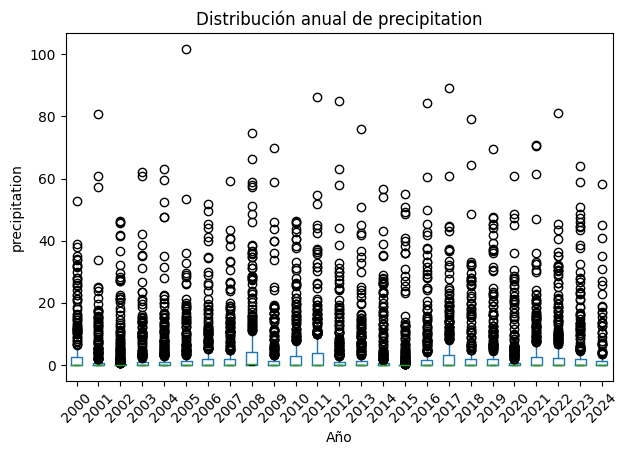

In [ ]:
# Crear columna con el año
df["year"] = df["date"].dt.year

# Boxplot por año de la variable seleccionada
variable = "precipitation"  # <-- Cambia por la variable que quieras analizar, importante para tu EDA

plt.figure(figsize=(18,6))
df.boxplot(column=variable, by="year", grid=False, showfliers=True)  # showfliers=False quita outliers extremos, True los deja
plt.title(f"Distribución anual de {variable}")
plt.suptitle("")
plt.xlabel("Año")
plt.ylabel(variable)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

<Figure size 1800x600 with 0 Axes>

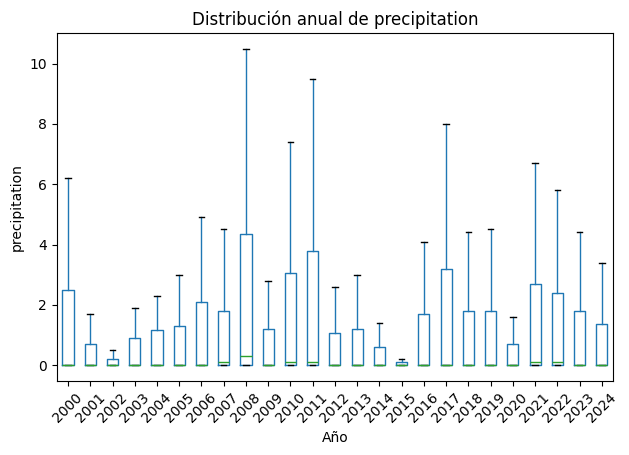

In [ ]:
# Crear columna con el año
df["year"] = df["date"].dt.year
variable = "precipitation"

plt.figure(figsize=(18,6))
df.boxplot(column=variable, by="year", grid=False, showfliers=False)  # showfliers=False quita outliers extremos, True los deja
plt.title(f"Distribución anual de {variable}")
plt.suptitle("")
plt.xlabel("Año")
plt.ylabel(variable)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

1. Se observa que las precipitaciones anuales presentan numerosos valores atípicos (outliers), lo que indica la existencia de días con precipitaciones más intensas. Estos picos se presentan consistentemente a lo largo de todos los años registrados.  
**Impacto en el Modelo:** Estos datos extremos podrían sesgar el entrenamiento del modelo y la función de pérdida (como el MSE), ya que son valores que se salen de las escalas normales de referencia.
**Acciónes a tener encuanta:** Es necesario aplicar un proceso de normalización a la variable objetivo para evitar que los modelos asignen pesos desproporcionados a estos valores atípicos.
2. Se observa una presencia dominante de datos nulos (cero) en la precipitación. Esto puede deberse a la ausencia real de lluvia o, en menor medida, a fallas en la carga de la información
3. Las cajas y las medianas mantienen una representación constante durante todos los años observados, aunque sus bigotes presenten diferentes largos, lo cual sugiere varianiliadd en los datos.





###Temperatura

<Figure size 1800x600 with 0 Axes>

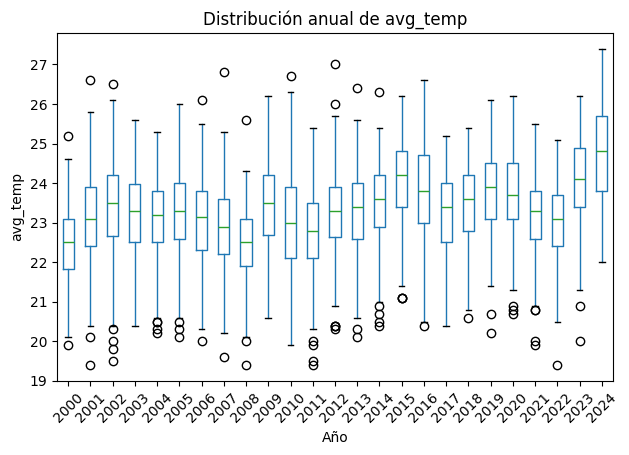

In [ ]:
# Boxplot por año de la variable seleccionada
variable = "avg_temp"

plt.figure(figsize=(18,6))
df.boxplot(column=variable, by="year", grid=False, showfliers=True)  # showfliers=False quita outliers extremos, True los deja
plt.title(f"Distribución anual de {variable}")
plt.suptitle("")
plt.xlabel("Año")
plt.ylabel(variable)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Se observan pocos valores atípicos (outliers) en la temperatura promedio, y ninguno de estos valores está marcado como un valor nulo (cero). Estos valores atípicos se presentan consistentemente durante todos los años del periodo analizado, ya sean dias con temperaturas mas calidas en menor mediada con respecto a los frios.

Además, se observa que se ha presentado una variación de la mediana de las temperaturas con una ligera tendencia a un crecimiento a lo largo del periodo (calentamiento).Sin embargo, en general, las cajas y sus bigotes presentan una variabilidad constante,esto implica que la distribución de la temperatura diaria se mantiene estable

<Figure size 1800x600 with 0 Axes>

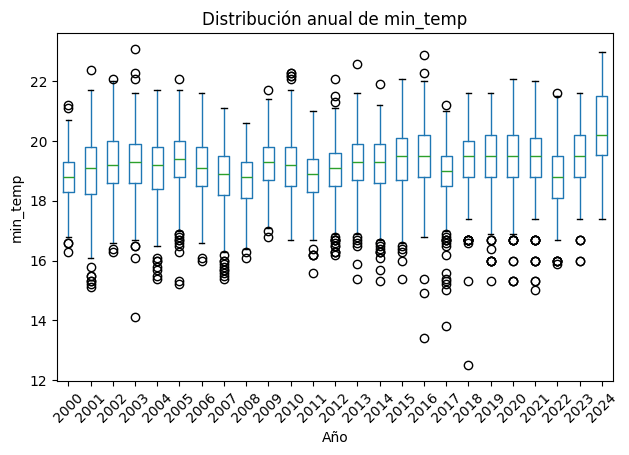

In [ ]:
# Boxplot por año de la variable seleccionada
variable = "min_temp"  # <-- Cambia por la variable que quieras analizar, importante para tu EDA

plt.figure(figsize=(18,6))
df.boxplot(column=variable, by="year", grid=False, showfliers=True)  # showfliers=False quita outliers extremos, True los deja
plt.title(f"Distribución anual de {variable}")
plt.suptitle("")
plt.xlabel("Año")
plt.ylabel(variable)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

<Figure size 1800x600 with 0 Axes>

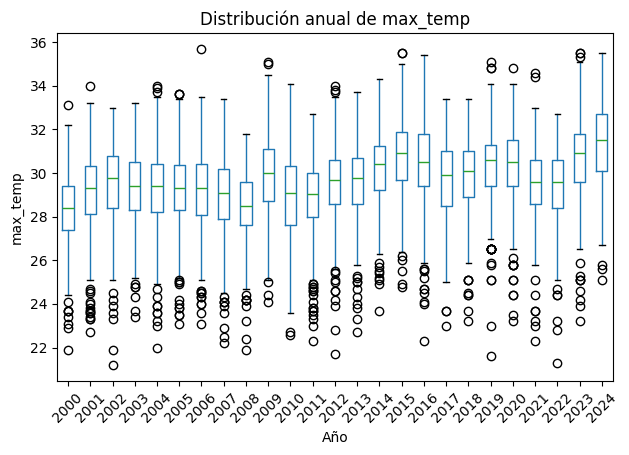

In [ ]:
# Boxplot por año de la variable seleccionada
variable = "max_temp"  # <-- Cambia por la variable que quieras analizar, importante para tu EDA

plt.figure(figsize=(18,6))
df.boxplot(column=variable, by="year", grid=False, showfliers=True)  # showfliers=False quita outliers extremos, True los deja
plt.title(f"Distribución anual de {variable}")
plt.suptitle("")
plt.xlabel("Año")
plt.ylabel(variable)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

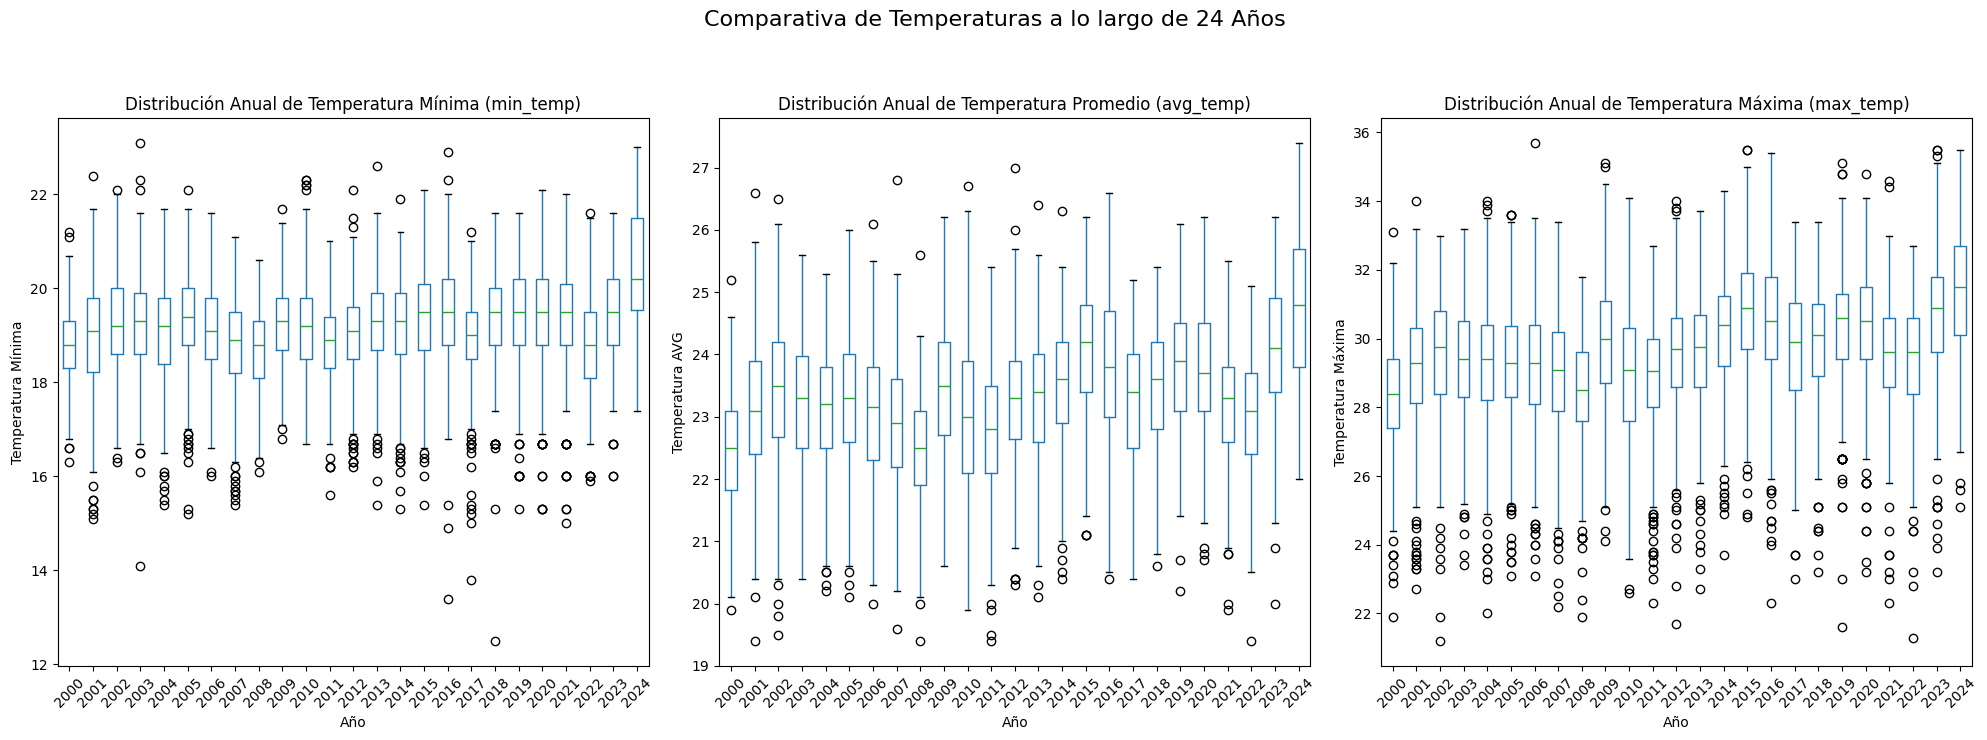

In [ ]:
fig, axes = plt.subplots(
    nrows=1,
    ncols=3,
    figsize=(20, 7),
    sharey=False # Mantiene los ejes Y independientes
)

# Graficar min_temp en el primer eje (índice 0)
df.boxplot(column='min_temp', by="year", ax=axes[0], grid=False, showfliers=True)
axes[0].set_title("Distribución Anual de Temperatura Mínima (min_temp)")
axes[0].set_xlabel("Año")
axes[0].set_ylabel("Temperatura Mínima")
axes[0].tick_params(axis='x', rotation=45) # Rotar etiquetas para mejor lectura

# Graficar max_temp en el segundo eje (índice 1)
df.boxplot(column='avg_temp', by="year", ax=axes[1], grid=False, showfliers=True)
axes[1].set_title("Distribución Anual de Temperatura Promedio (avg_temp)")
axes[1].set_xlabel("Año")
axes[1].set_ylabel("Temperatura AVG")
axes[1].tick_params(axis='x', rotation=45) # Rotar etiquetas

# Graficar max_temp en el segundo eje (índice 2)
df.boxplot(column='max_temp', by="year", ax=axes[2], grid=False, showfliers=True)
axes[2].set_title("Distribución Anual de Temperatura Máxima (max_temp)")
axes[2].set_xlabel("Año")
axes[2].set_ylabel("Temperatura Máxima")
axes[2].tick_params(axis='x', rotation=45) # Rotar etiquetas

# 5. Ajustar el diseño y mostrar el supertítulo
plt.suptitle("Comparativa de Temperaturas a lo largo de 24 Años", y=1.05, fontsize=16)
plt.tight_layout()
plt.show()

las variables de temperatura presenta valores atipicos durante todos los años los que indca que hay dias de que se presenta dias mas frios o calidps.

Identificación de Outliers: Se confirma que tanto la temperatura mínima (min_temp) como la temperatura máxima (max_temp) presentan valores atípicos (outliers) a lo largo de todos los años, esto indica la ocurrencia constante de días extremadamente fríos o cálidos que se salen de la distribución normal.

Tendencia de Calentamiento: Se confirma la ligera tendencia al aumento de las temperaturas observada previamente en avg_temp y evidenciada por el desplazamiento ascendente de las medianas a lo largo del tiempo.

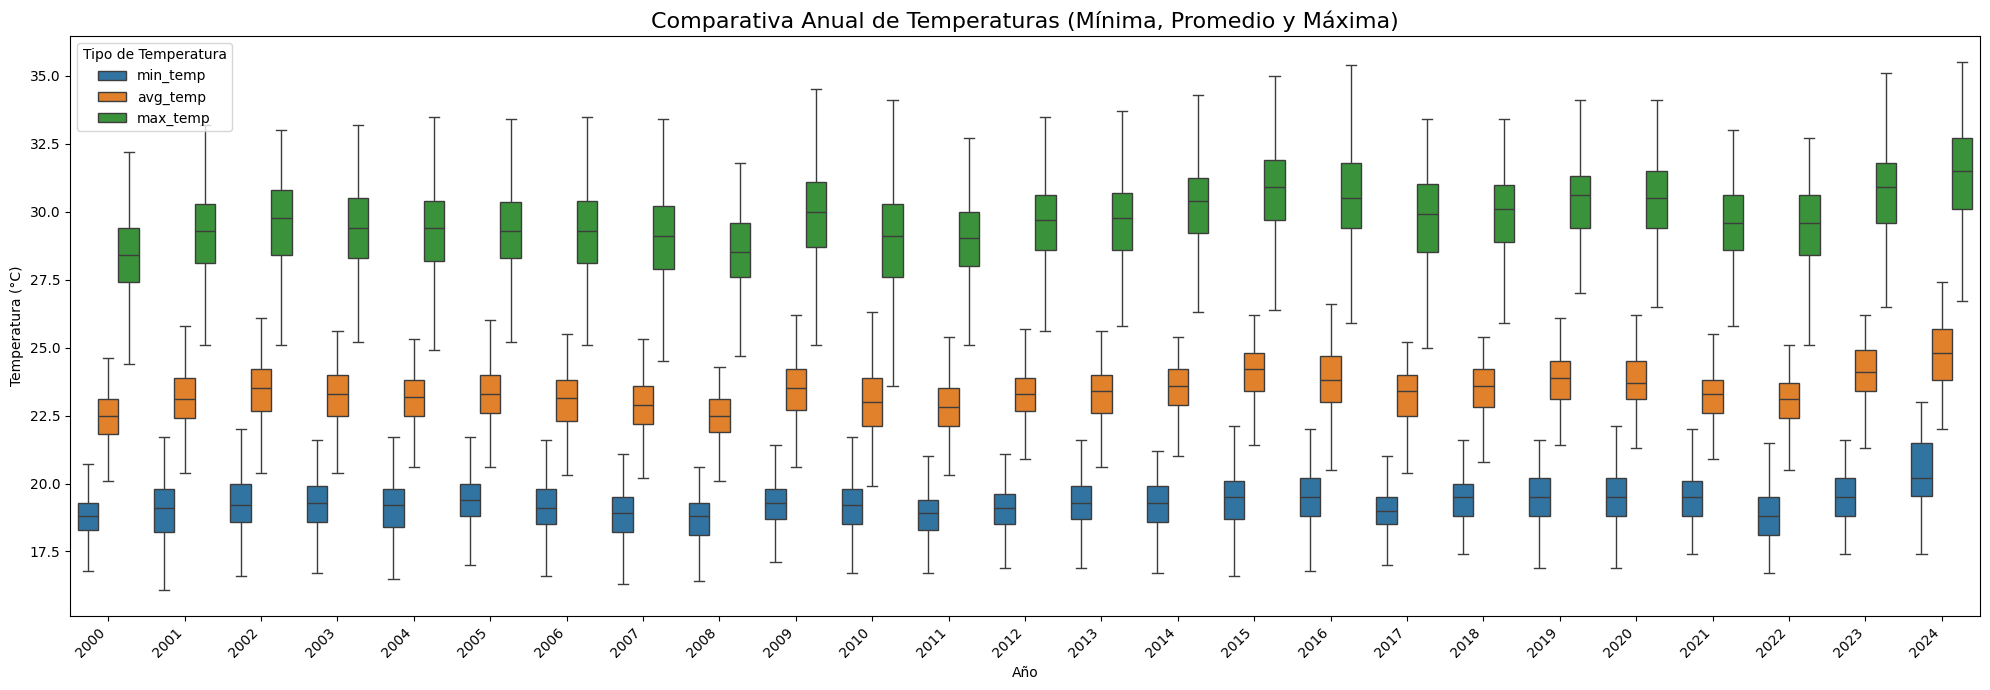

In [ ]:
import seaborn as sns # Necesitarás esta librería: pip install seaborn
columnas_a_comparar = ['min_temp', 'avg_temp', 'max_temp']
df_melted = df.melt(
    id_vars=['year'],
    value_vars=columnas_a_comparar,
    var_name='Tipo_Temperatura',
    value_name='Temperatura'
)
plt.figure(figsize=(20, 7))
sns.boxplot(
    data=df_melted,
    x='year',
    y='Temperatura',
    hue='Tipo_Temperatura',
    showfliers=False # Se recomienda ocultar outliers para que la gráfica no se sature
)
plt.title("Comparativa Anual de Temperaturas (Mínima, Promedio y Máxima)", fontsize=16)
plt.xlabel("Año")
plt.ylabel("Temperatura (°C)")
plt.xticks(rotation=45, ha='right')
plt.legend(title='Tipo de Temperatura', loc='upper left')
plt.tight_layout()
plt.show()

Las temperaturas influencian las precipitaciones de dos maneras principales: primero, el aire más caliente puede retener más vapor de agua, lo que aumenta la cantidad de agua disponible para la formación de nubes y precipitaciones intensas. Segundo, la temperatura del aire determina el tipo de precipitación: si está por encima del punto de congelación (0°C), cae en forma de lluvia, pero si está por debajo, puede ser nieve, aguanieve o lluvia helada

###Humeadad Relativa

<Figure size 1800x600 with 0 Axes>

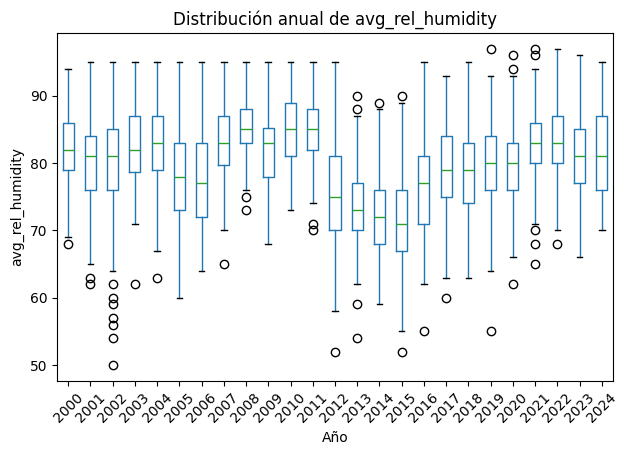

In [ ]:
# Boxplot por año de la variable seleccionada
variable = "avg_rel_humidity"  # <-- Cambia por la variable que quieras analizar, importante para tu EDA

plt.figure(figsize=(18,6))
df.boxplot(column=variable, by="year", grid=False, showfliers=True)  # showfliers=False quita outliers extremos, True los deja
plt.title(f"Distribución anual de {variable}")
plt.suptitle("")
plt.xlabel("Año")
plt.ylabel(variable)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

la grafica de la Humedad relativa promedio diaria durante un perido de 24 años se puede observavar que presenta las siguientes caracteristicas:

1. **Presencia de Valores Atípicos:** Se observa la presencia de valores atípicos (outliers), aunque su frecuencia no es constante a lo largo de toda la serie. En algunos años, estos son más numerosos o extremos, y en otros son escasos o ausentes. **Impacto Predictivo** de estos datos es que representan días con condiciones de humedad extremadamente alta o baja, y en la relación a las temperaturas (días más cálidos o fríos) es clave, pues la temperatura es el principal impulsor de la humedad.

2. **Oscilación y Baja Estacionalidad:** Los gráficos presentan una marcada variación en la altura de sus cajas y en la longitud de sus bigotes. Esto indica una oscilación en la distribución anual de la humedad y una poca estacionalidad definida a largo plazo diferente a los datos observados de temperatura. Esta variable es fundamiental para la prediccion y los modelos en base a memoria tendran a favor ya que pueden capturar mejor la dependencias y osilaciomes mostradas.

<Figure size 1800x600 with 0 Axes>

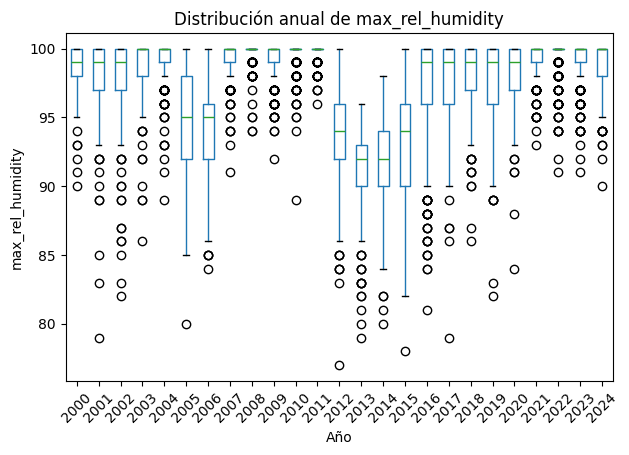

In [ ]:
# Boxplot por año de la variable seleccionada
variable = "max_rel_humidity"  # <-- Cambia por la variable que quieras analizar, importante para tu EDA

plt.figure(figsize=(18,6))
df.boxplot(column=variable, by="year", grid=False, showfliers=True)  # showfliers=False quita outliers extremos, True los deja
plt.title(f"Distribución anual de {variable}")
plt.suptitle("")
plt.xlabel("Año")
plt.ylabel(variable)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

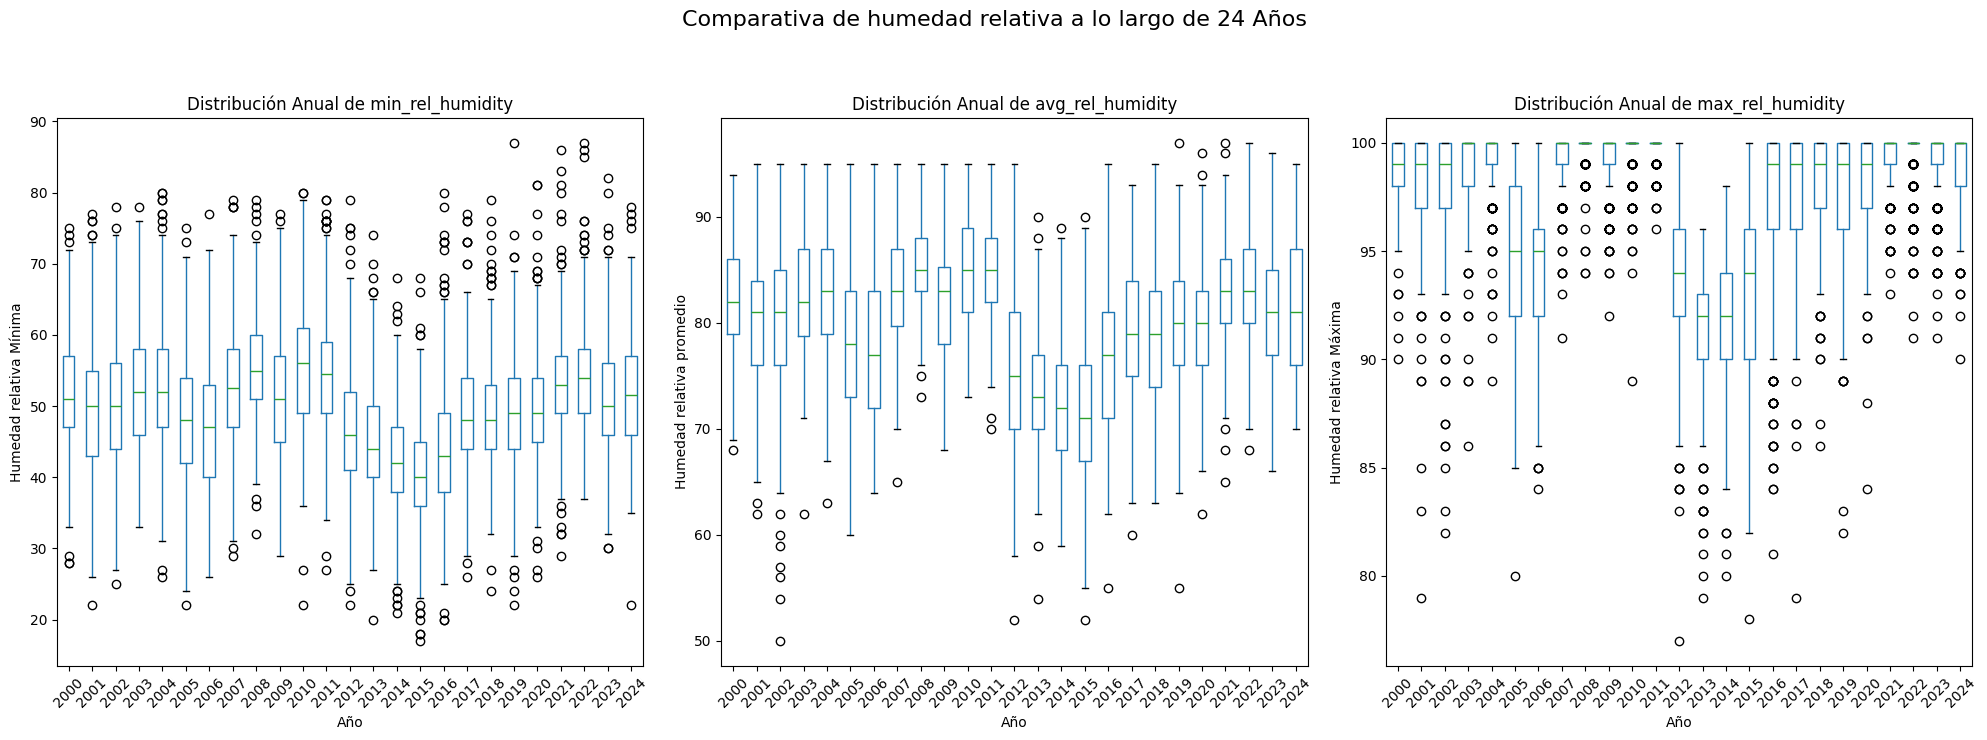

In [ ]:
fig, axes = plt.subplots(
    nrows=1,
    ncols=3,
    figsize=(20, 7),
    sharey=False # Mantiene los ejes Y independientes
)
df.boxplot(column='min_rel_humidity', by="year", ax=axes[0], grid=False, showfliers=True)
axes[0].set_title("Distribución Anual de min_rel_humidity")
axes[0].set_xlabel("Año")
axes[0].set_ylabel("Humedad relativa Mínima")
axes[0].tick_params(axis='x', rotation=45) # Rotar etiquetas para mejor lectura
df.boxplot(column='avg_rel_humidity', by="year", ax=axes[1], grid=False, showfliers=True)
axes[1].set_title("Distribución Anual de avg_rel_humidity")
axes[1].set_xlabel("Año")
axes[1].set_ylabel("Humedad relativa promedio")
axes[1].tick_params(axis='x', rotation=45) # Rotar etiquetas
df.boxplot(column='max_rel_humidity', by="year", ax=axes[2], grid=False, showfliers=True)
axes[2].set_title("Distribución Anual de max_rel_humidity")
axes[2].set_xlabel("Año")
axes[2].set_ylabel("Humedad relativa Máxima")
axes[2].tick_params(axis='x', rotation=45) # Rotar etiquetas

plt.suptitle("Comparativa de humedad relativa a lo largo de 24 Años", y=1.05, fontsize=16)
plt.tight_layout()
plt.show()

Las humedades relativas confirman el comportamiento de la serie de poca estacionalidad consistente, ya que presenta una alta variabilidad de sus medianas, lo que indica la ausencia de un patrón claro durante la repetición anual de la humedad, así como la presencia de una oscilación donde hay presencia de alta o baja humedad en diferentes periodos anuales.

Con los valores extremos, se observa una gran dispersión, así como datos atípicos en regiones bajas de los datos medidos, lo que indicaría poca humedad o aire extremadamente seco.

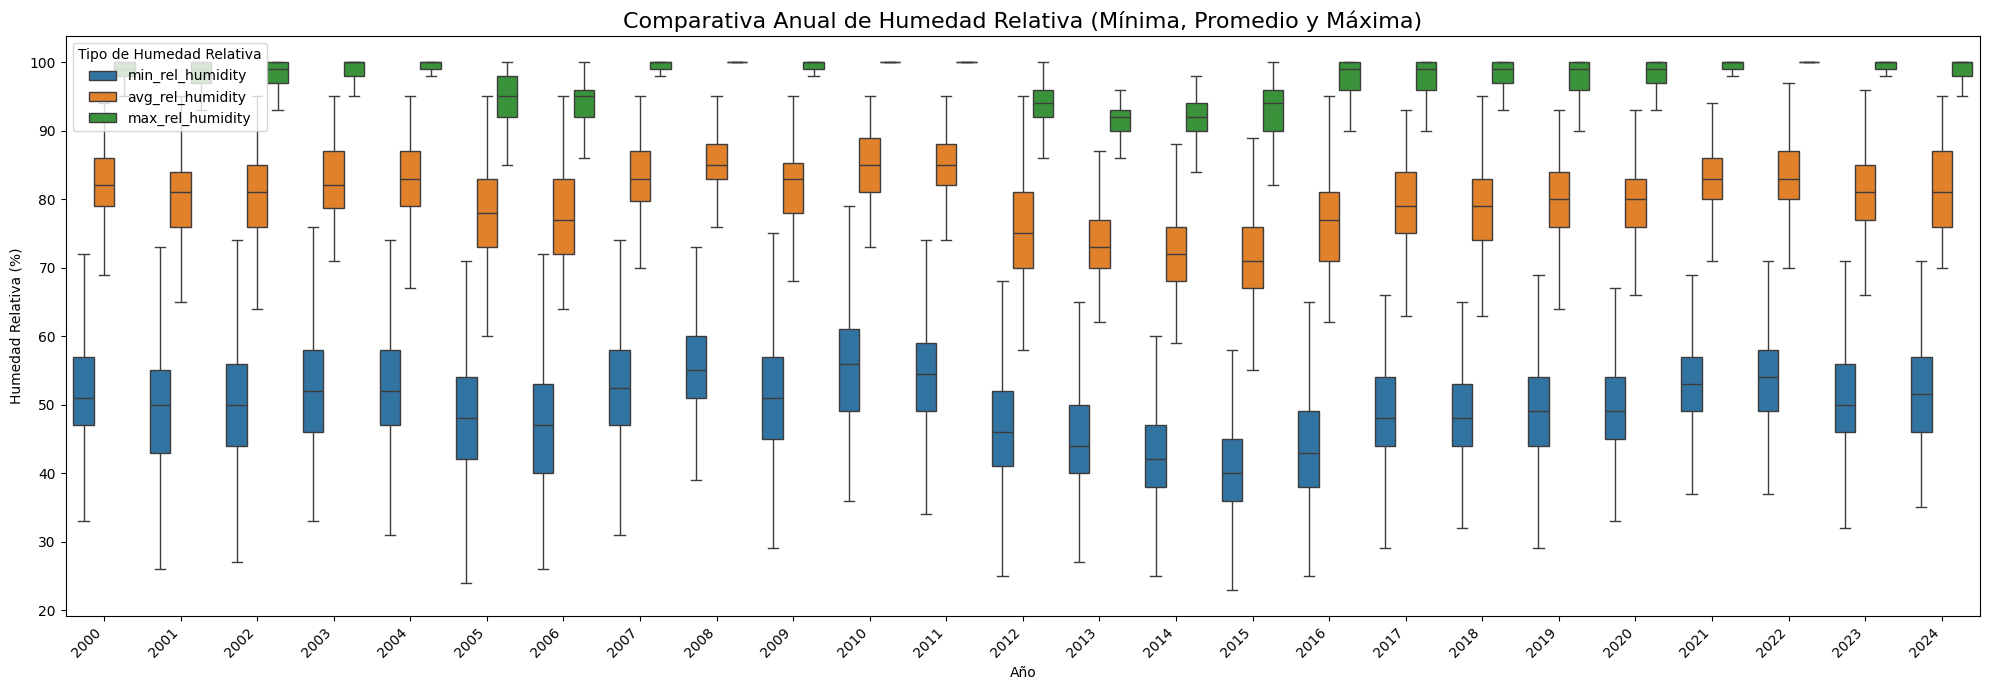

In [ ]:
columnas_a_comparar = ['min_rel_humidity', 'avg_rel_humidity', 'max_rel_humidity']
df_melted = df.melt(
    id_vars=['year'],
    value_vars=columnas_a_comparar,
    var_name='Tipo_Humedad_relativa',
    value_name='Humedad_relativa'
)
plt.figure(figsize=(20, 7))
sns.boxplot(
    data=df_melted,
    x='year',
    y='Humedad_relativa',
    hue='Tipo_Humedad_relativa',
    showfliers=False # Se recomienda ocultar outliers para que la gráfica no se sature
)
plt.title("Comparativa Anual de Humedad Relativa (Mínima, Promedio y Máxima)", fontsize=16)
plt.xlabel("Año")
plt.ylabel("Humedad Relativa (%)")
plt.xticks(rotation=45, ha='right')
plt.legend(title='Tipo de Humedad Relativa', loc='upper left')
plt.tight_layout()
plt.show()

Se reafirma un comportamiento poco estacional y altamente variable, lo cual es más evidente en la humedad mínima. Es decir, no se observa un patrón anual claro. Este comportamiento podría estar asociado a condiciones atmosféricas extremas o a la influencia de eventos climáticos no recurrentes. Por otro lado, los valores de humedad relativa promedio y máxima presentan un patrón ligeramente más definido, siendo la humedad máxima la que muestra un comportamiento menos oscilante y más estable a lo largo del tiempo.

###Radiacion Solar

<Figure size 1800x600 with 0 Axes>

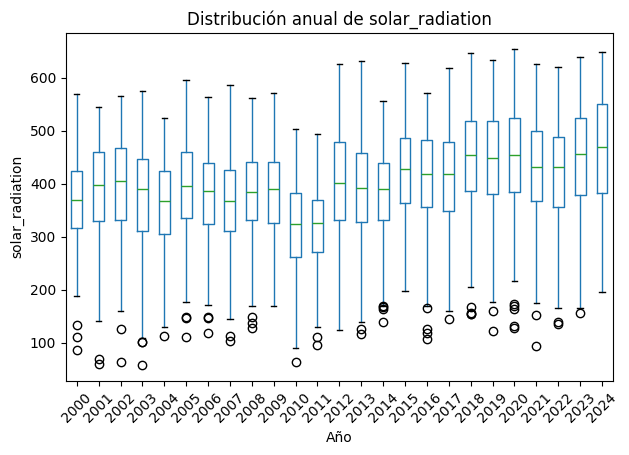

In [ ]:
# Boxplot por año de la variable seleccionada
variable = "solar_radiation"  # <-- Cambia por la variable que quieras analizar, importante para tu EDA

plt.figure(figsize=(18,6))
df.boxplot(column=variable, by="year", grid=False, showfliers=True)  # showfliers=False quita outliers extremos, True los deja
plt.title(f"Distribución anual de {variable}")
plt.suptitle("")
plt.xlabel("Año")
plt.ylabel(variable)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

la radiacion solar diaria tiene una relacion en el comportemiento de la temperatura ya que se observa que tienen un patron semejante, el cuales una ligera tendencia ascendente en relacion a la mediana a lo largo de los años, ademas que presenta una estabilidad que se repite lo que indca una estacionalidad.
con respecto a los valores aticos estos se presnten en la region baja de los persentiles, en toda la serie.


###Evaporacion

<Figure size 1800x600 with 0 Axes>

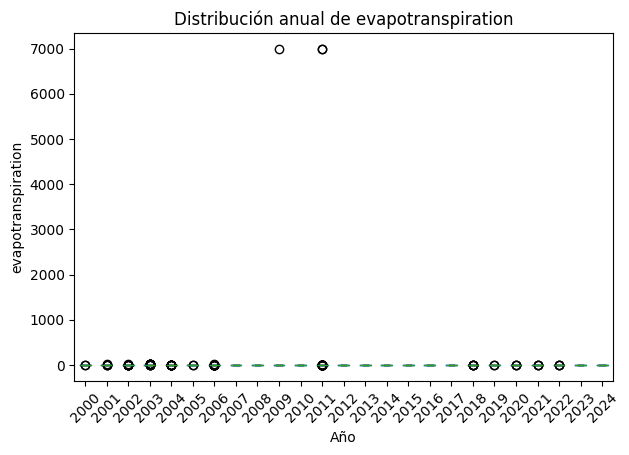

In [ ]:
# Boxplot por año de la variable seleccionada
variable = "evapotranspiration"  # <-- Cambia por la variable que quieras analizar, importante para tu EDA

plt.figure(figsize=(18,6))
df.boxplot(column=variable, by="year", grid=False, showfliers=True)  # showfliers=False quita outliers extremos, True los deja
plt.title(f"Distribución anual de {variable}")
plt.suptitle("")
plt.xlabel("Año")
plt.ylabel(variable)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

la evaporacion presenta dos valors atipcos de gran escala, ay que se observa un comprotamiento mas cercano a cero dentro de la serie, estos datos extremos indican que esos dias fueron mas despejaso y mas secos.

<Figure size 1800x600 with 0 Axes>

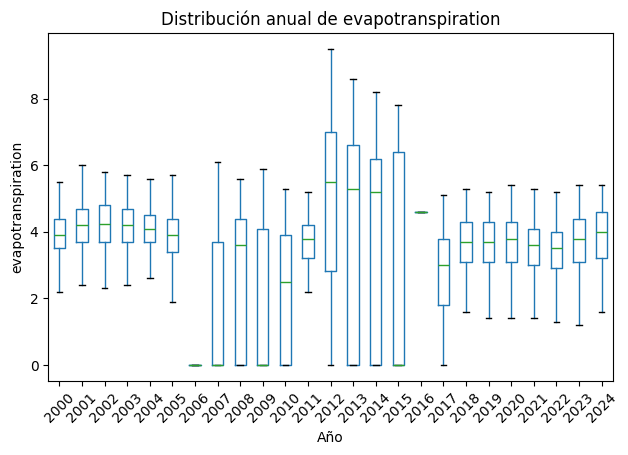

In [ ]:
# Boxplot por año de la variable seleccionada
variable = "evapotranspiration"  # <-- Cambia por la variable que quieras analizar, importante para tu EDA

plt.figure(figsize=(18,6))
df.boxplot(column=variable, by="year", grid=False, showfliers=False)  # showfliers=False quita outliers extremos, True los deja
plt.title(f"Distribución anual de {variable}")
plt.suptitle("")
plt.xlabel("Año")
plt.ylabel(variable)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Se observa que, aunque los valores de evaporación tienden a ser cercanos a cero en la escala anterior, en esta se aprecia mejor el comportamiento de la serie Se concluye que presenta períodos de gran oscilación y volatilidad en los datos medidos durante los años 2012-2016, y en los periodos de 2000 al 2005 y del 2017 al 2024 se observa una notable estabilidad en sus oscilaciones, donde los bigotes y las cajas son más consistentes. Es decir, existe una estacionalidad con patrones más claros

**Conclusion**

esto indica la nesecidad de normalizar todas las variables debido a la presencia de datos atipicos muy extremos o sus datos marcar una escala muy diferente entre ellos. ademas se observa que las temperaturas y la rediacion solar presentan una estacionalidad estable.

## Visualicemos las series de tiempo

###precipitation

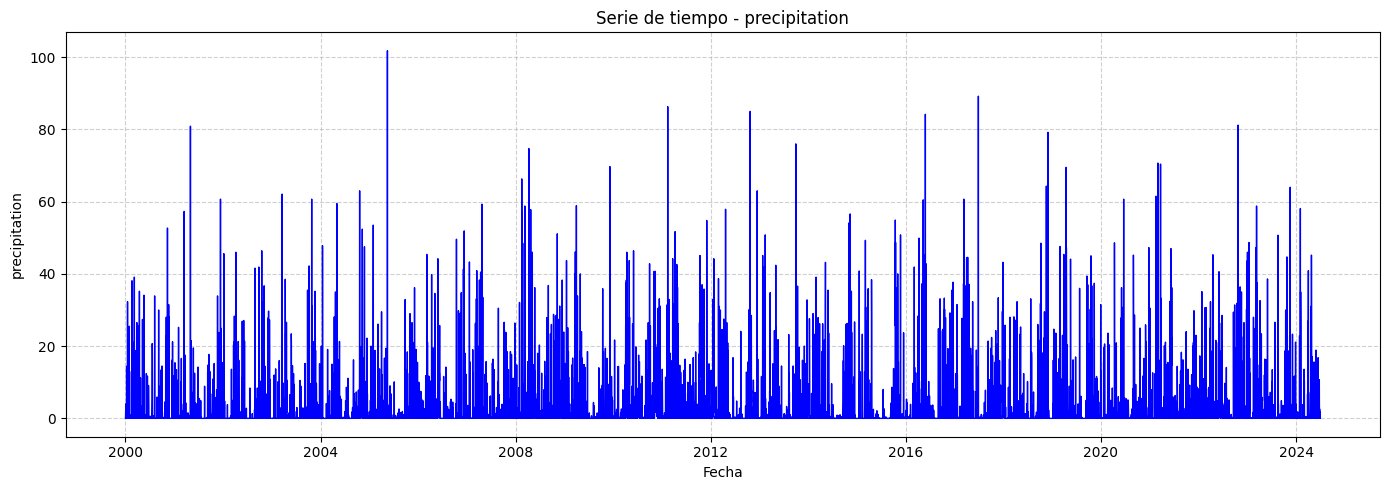

In [ ]:
df["date"] = pd.to_datetime(df["date"])
df = df.sort_values("date") # Tengan en cuenta asegurar el ordenamiento de esta serie de tiempo

# Visualizar la serie de tiempo de precipitación
plt.figure(figsize=(14,5))
plt.plot(df["date"], df["precipitation"], color="blue", linewidth=1)
plt.title("Serie de tiempo - precipitation")
plt.xlabel("Fecha")
plt.ylabel("precipitation")
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

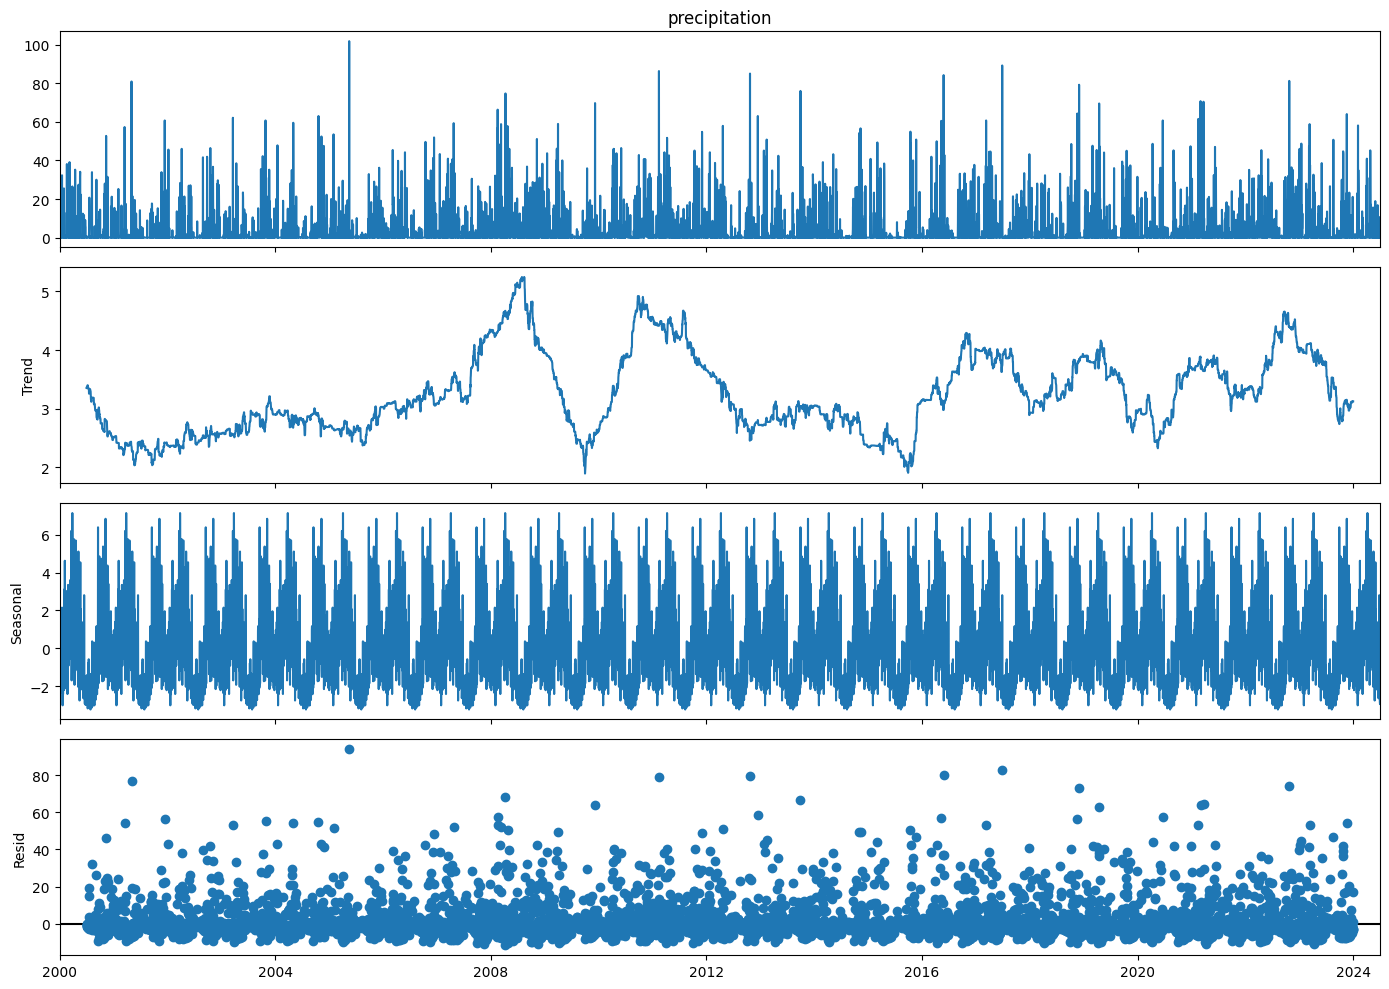

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
df1 = df.copy()
df1 = df1.set_index('date')
td_componentesadd1 = seasonal_decompose(
        df1["precipitation"],
        model="additive",
        period=365  # Analizar el ciclo anual
    )

# 3. Generar la figura con los componentes
fig1 = td_componentesadd1.plot()

# Ajustar el tamaño para que los 4 gráficos se vean bien
fig1.set_size_inches((14, 10))
fig1.tight_layout()
plt.show()

FAlta conclusion de los graficos

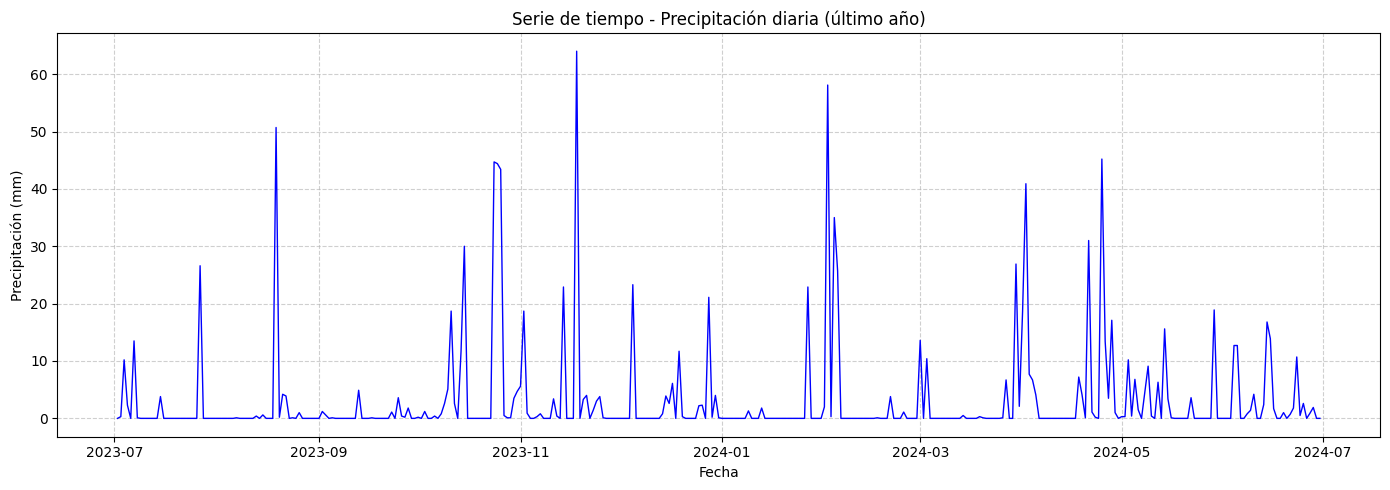

In [ ]:
# Graficar solo el último año (365 días)
plt.figure(figsize=(14,5))
plt.plot(df.tail(365)["date"], df.tail(365)["precipitation"], color="blue", linewidth=1)
plt.title("Serie de tiempo - Precipitación diaria (último año)")
plt.xlabel("Fecha")
plt.ylabel("Precipitación (mm)")
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

###TEMPERATURAS

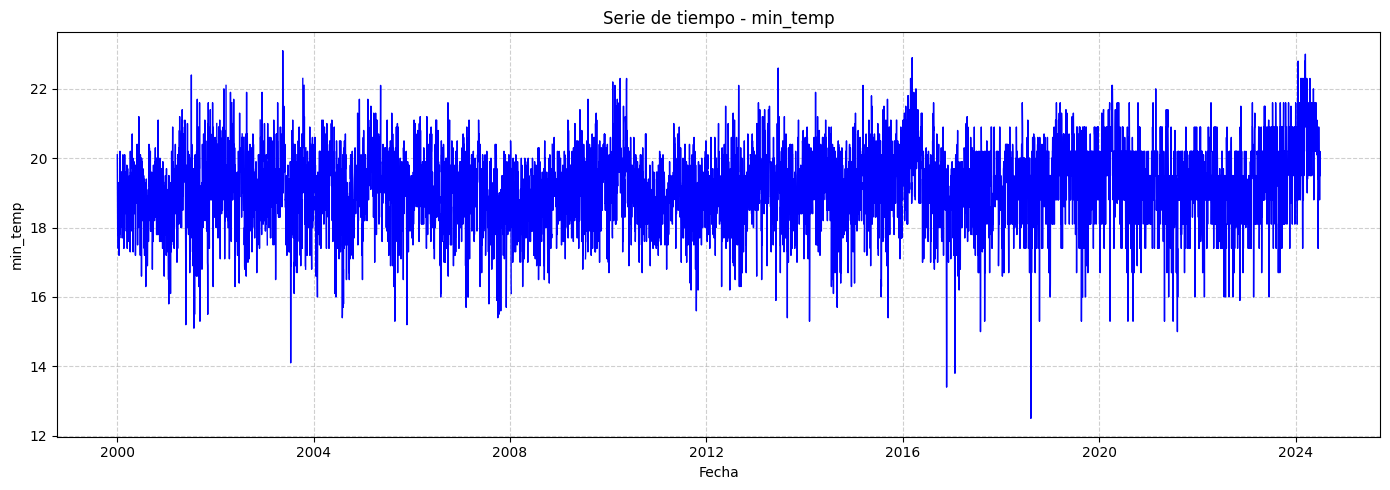

In [ ]:
df["date"] = pd.to_datetime(df["date"])
df = df.sort_values("date") # Tengan en cuenta asegurar el ordenamiento de esta serie de tiempo

# Visualizar la serie de tiempo de precipitación
plt.figure(figsize=(14,5))
plt.plot(df["date"], df["min_temp"], color="blue", linewidth=1)
plt.title("Serie de tiempo - min_temp")
plt.xlabel("Fecha")
plt.ylabel("min_temp")
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

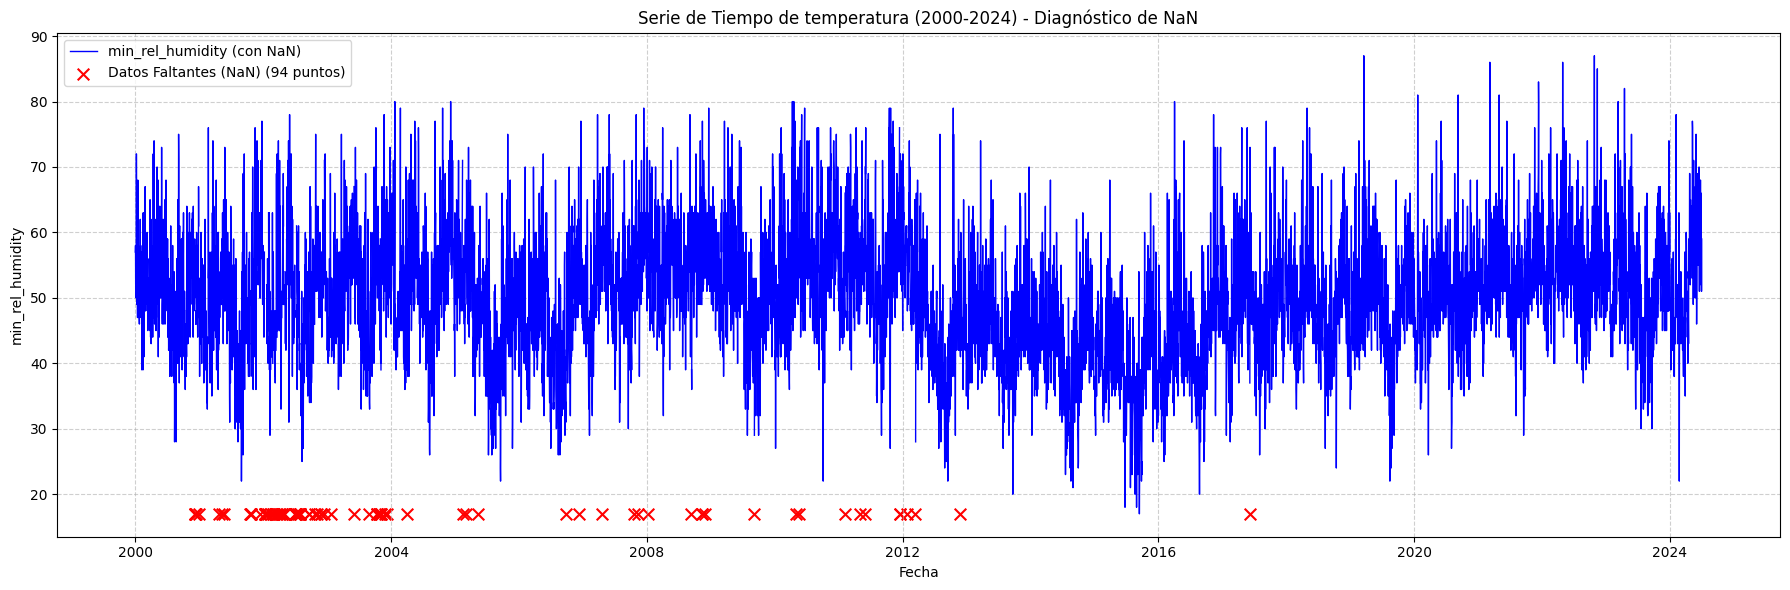

Total de NaN encontrados: 94


In [ ]:
df["date"] = pd.to_datetime(df["date"])
df = df.sort_values("date") # Tengan en cuenta asegurar el ordenamiento de esta serie de tiempo

# --- 1. VISUALIZAR LA SERIE COMPLETA (2000-2024) ---
plt.figure(figsize=(18, 6))

# Ploteamos la serie con los NaN (la línea se romperá donde hay NaN)
plt.plot(df["date"],
         df["min_rel_humidity"],
         color="blue",
         linewidth=1,
         label="min_rel_humidity (con NaN)")

# 2. Resaltar todos los puntos Faltantes (NaN)
nan_values = df[df["min_rel_humidity"].isnull()]

if not nan_values.empty:
    # Usamos el valor mínimo visible para posicionar las marcas rojas,
    # para que no interfieran con la línea.
    min_visible_humidity = df["min_rel_humidity"].min()

    plt.scatter(nan_values["date"],
                [min_visible_humidity] * len(nan_values),
                color='red',
                marker='x',
                s=70,
                label=f'Datos Faltantes (NaN) ({len(nan_values)} puntos)')
else:
    print("¡No se encontraron NaN en min_rel_humidity! La serie ya está completa.")


plt.title("Serie de Tiempo de temperatura (2000-2024) - Diagnóstico de NaN")
plt.xlabel("Fecha")
plt.ylabel("min_rel_humidity")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

# 3. Diagnóstico de Fechas Específicas
print(f"Total de NaN encontrados: {nan_values.shape[0]}")

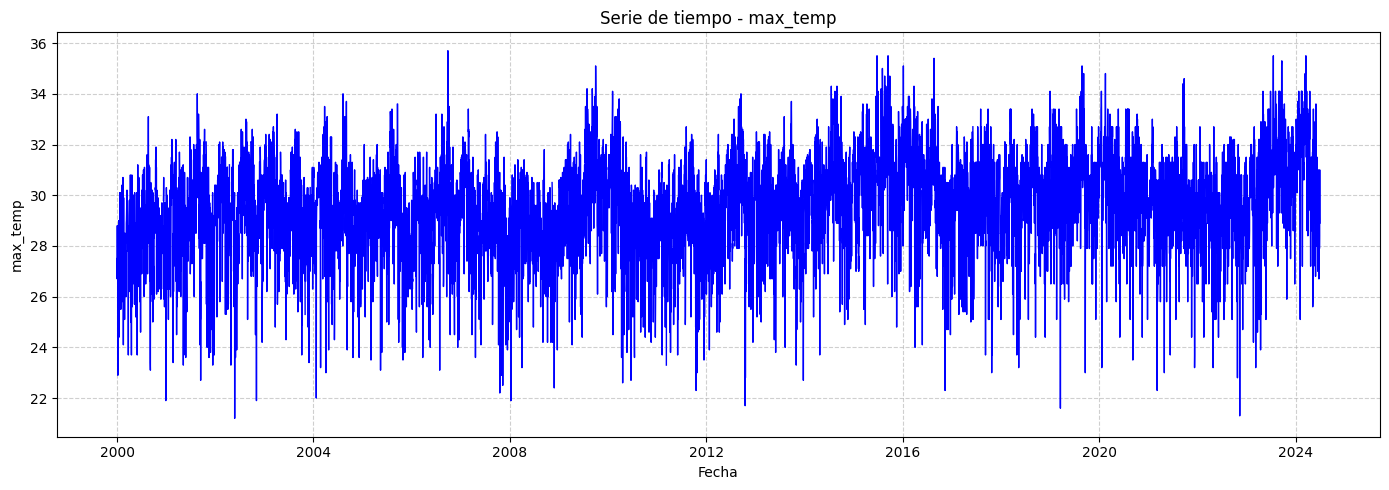

In [ ]:
df["date"] = pd.to_datetime(df["date"])
df = df.sort_values("date") # Tengan en cuenta asegurar el ordenamiento de esta serie de tiempo

# Visualizar la serie de tiempo de precipitación
plt.figure(figsize=(14,5))
plt.plot(df["date"], df["max_temp"], color="blue", linewidth=1)
plt.title("Serie de tiempo - max_temp")
plt.xlabel("Fecha")
plt.ylabel("max_temp")
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

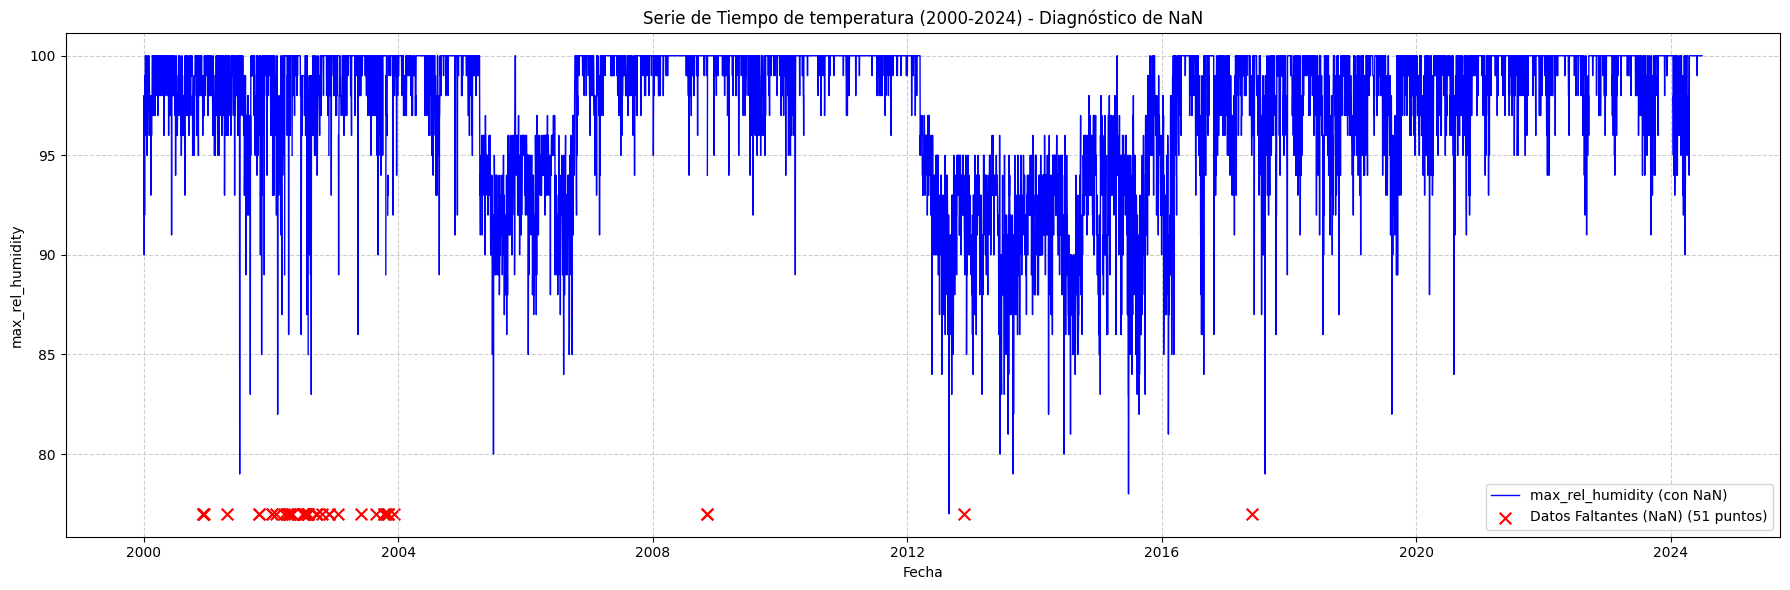

Total de NaN encontrados: 51


In [ ]:
df["date"] = pd.to_datetime(df["date"])
df = df.sort_values("date") # Tengan en cuenta asegurar el ordenamiento de esta serie de tiempo

# --- 1. VISUALIZAR LA SERIE COMPLETA (2000-2024) ---
plt.figure(figsize=(18, 6))

# Ploteamos la serie con los NaN (la línea se romperá donde hay NaN)
plt.plot(df["date"],
         df["max_rel_humidity"],
         color="blue",
         linewidth=1,
         label="max_rel_humidity (con NaN)")

# 2. Resaltar todos los puntos Faltantes (NaN)
nan_values = df[df["max_rel_humidity"].isnull()]

if not nan_values.empty:
    # Usamos el valor mínimo visible para posicionar las marcas rojas,
    # para que no interfieran con la línea.
    min_visible_humidity = df["max_rel_humidity"].min()

    plt.scatter(nan_values["date"],
                [min_visible_humidity] * len(nan_values),
                color='red',
                marker='x',
                s=70,
                label=f'Datos Faltantes (NaN) ({len(nan_values)} puntos)')
else:
    print("¡No se encontraron NaN en max_rel_humidity! La serie ya está completa.")


plt.title("Serie de Tiempo de temperatura (2000-2024) - Diagnóstico de NaN")
plt.xlabel("Fecha")
plt.ylabel("max_rel_humidity")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

# 3. Diagnóstico de Fechas Específicas
print(f"Total de NaN encontrados: {nan_values.shape[0]}")

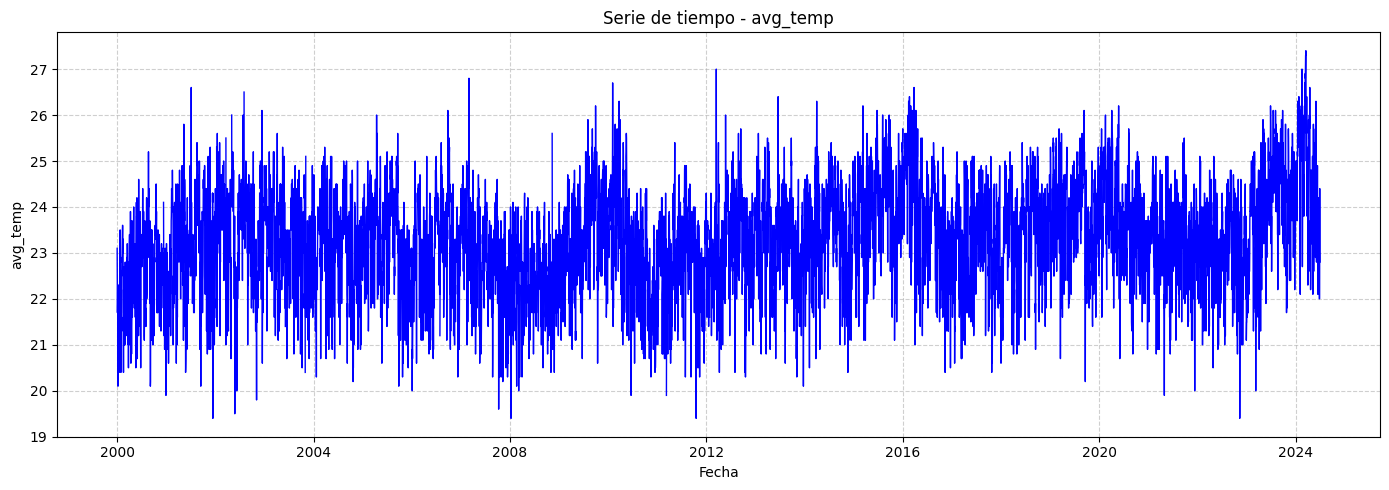

In [ ]:
df["date"] = pd.to_datetime(df["date"])
df = df.sort_values("date") # Tengan en cuenta asegurar el ordenamiento de esta serie de tiempo

# Visualizar la serie de tiempo de precipitación
plt.figure(figsize=(14,5))
plt.plot(df["date"], df["avg_temp"], color="blue", linewidth=1)
plt.title("Serie de tiempo - avg_temp")
plt.xlabel("Fecha")
plt.ylabel("avg_temp")
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

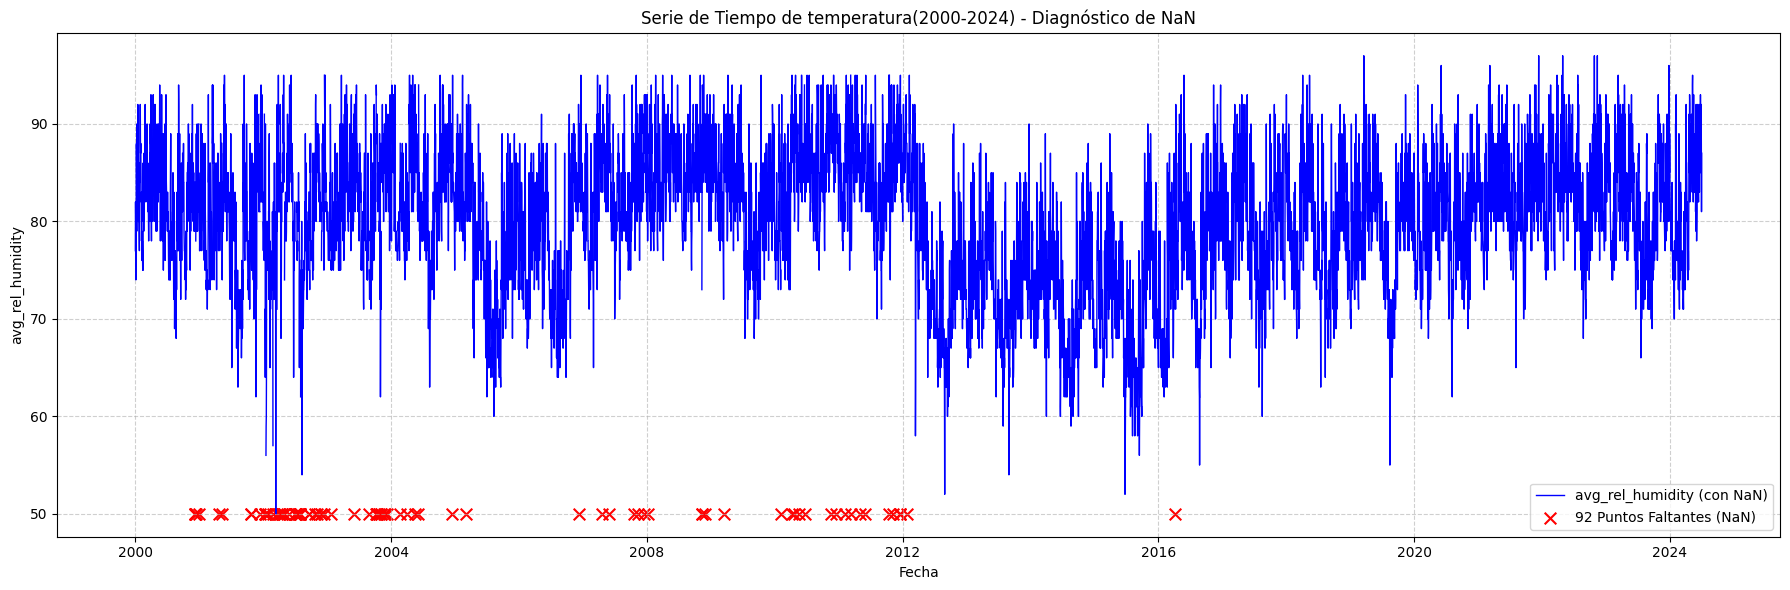

Total de NaN encontrados: 92


In [ ]:
df["date"] = pd.to_datetime(df["date"])
df = df.sort_values("date") # Tengan en cuenta asegurar el ordenamiento de esta serie de tiempo

# --- 1. VISUALIZAR LA SERIE COMPLETA (2000-2024) ---
plt.figure(figsize=(18, 6))

# Ploteamos la serie con los NaN (la línea se romperá donde hay NaN)
plt.plot(df["date"],
         df["avg_rel_humidity"],
         color="blue",
         linewidth=1,
         label="avg_rel_humidity (con NaN)")

# 2. Resaltar todos los puntos Faltantes (NaN)
nan_values = df[df["avg_rel_humidity"].isnull()]

if not nan_values.empty:
    # Usamos el valor mínimo visible para posicionar las marcas rojas,
    # para que no interfieran con la línea.
    min_visible_humidity = df["avg_rel_humidity"].min()

    plt.scatter(nan_values["date"],
                [min_visible_humidity] * len(nan_values),
                color='red',
                marker='x',
                s=70,
                label='92 Puntos Faltantes (NaN)')
else:
    print("¡No se encontraron NaN en avg_rel_humidity! La serie ya está completa.")


plt.title("Serie de Tiempo de temperatura(2000-2024) - Diagnóstico de NaN")
plt.xlabel("Fecha")
plt.ylabel("avg_rel_humidity")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

# 3. Diagnóstico de Fechas Específicas
print(f"Total de NaN encontrados: {nan_values.shape[0]}")

###Humedad Relativa

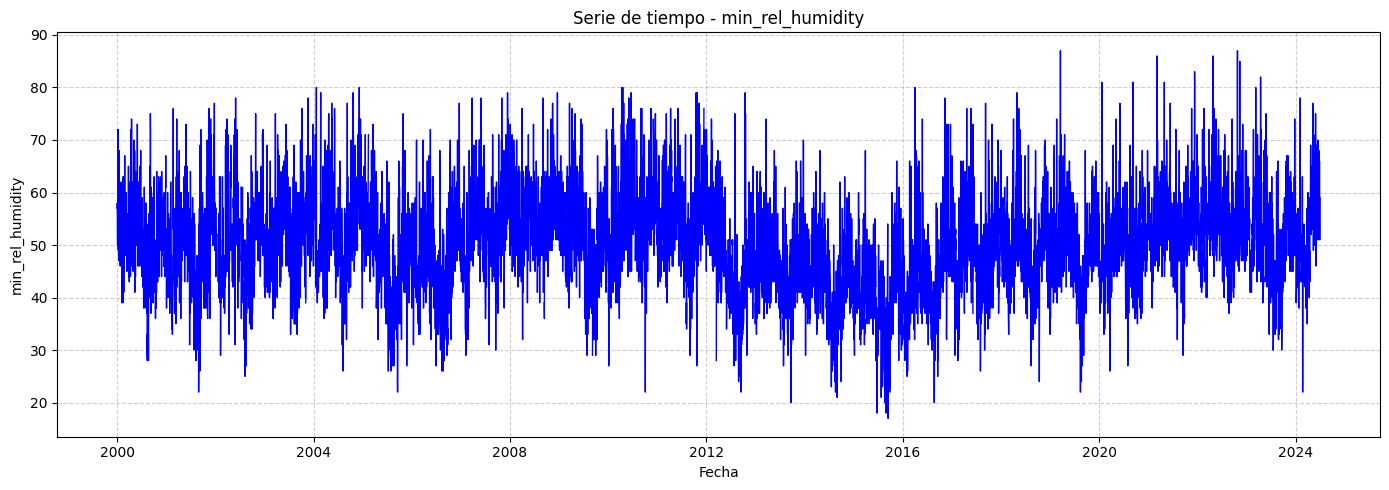

In [ ]:
df["date"] = pd.to_datetime(df["date"])
df = df.sort_values("date") # Tengan en cuenta asegurar el ordenamiento de esta serie de tiempo

# Visualizar la serie de tiempo de precipitación
plt.figure(figsize=(14,5))
plt.plot(df["date"], df["min_rel_humidity"], color="blue", linewidth=1)
plt.title("Serie de tiempo - min_rel_humidity")
plt.xlabel("Fecha")
plt.ylabel("min_rel_humidity")
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

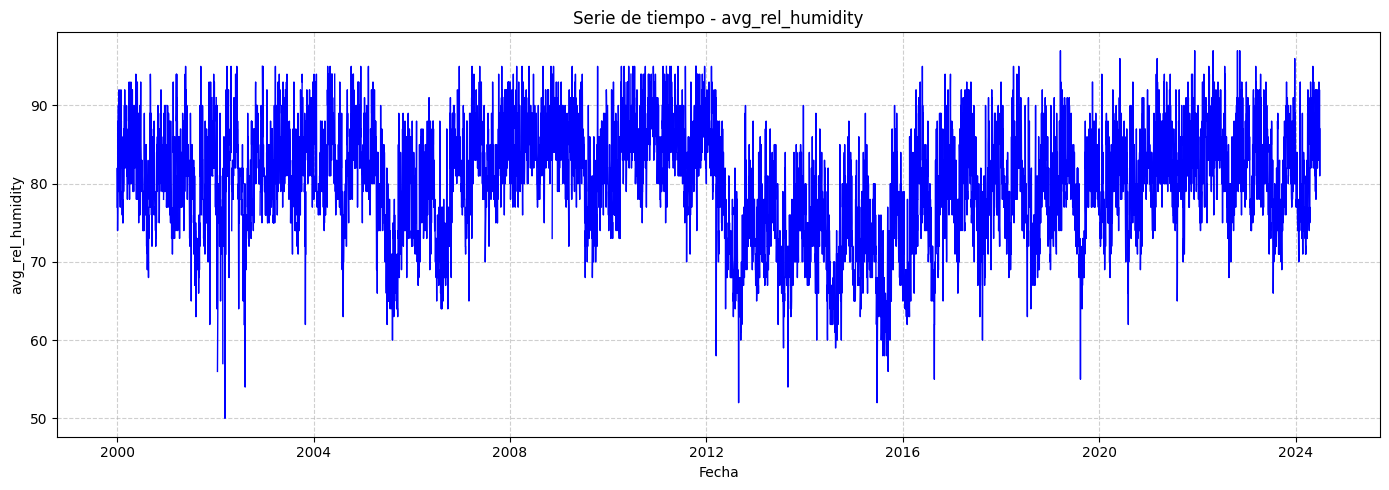

In [ ]:
df["date"] = pd.to_datetime(df["date"])
df = df.sort_values("date") # Tengan en cuenta asegurar el ordenamiento de esta serie de tiempo

# Visualizar la serie de tiempo de precipitación
plt.figure(figsize=(14,5))
plt.plot(df["date"], df["avg_rel_humidity"], color="blue", linewidth=1)
plt.title("Serie de tiempo - avg_rel_humidity")
plt.xlabel("Fecha")
plt.ylabel("avg_rel_humidity")
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

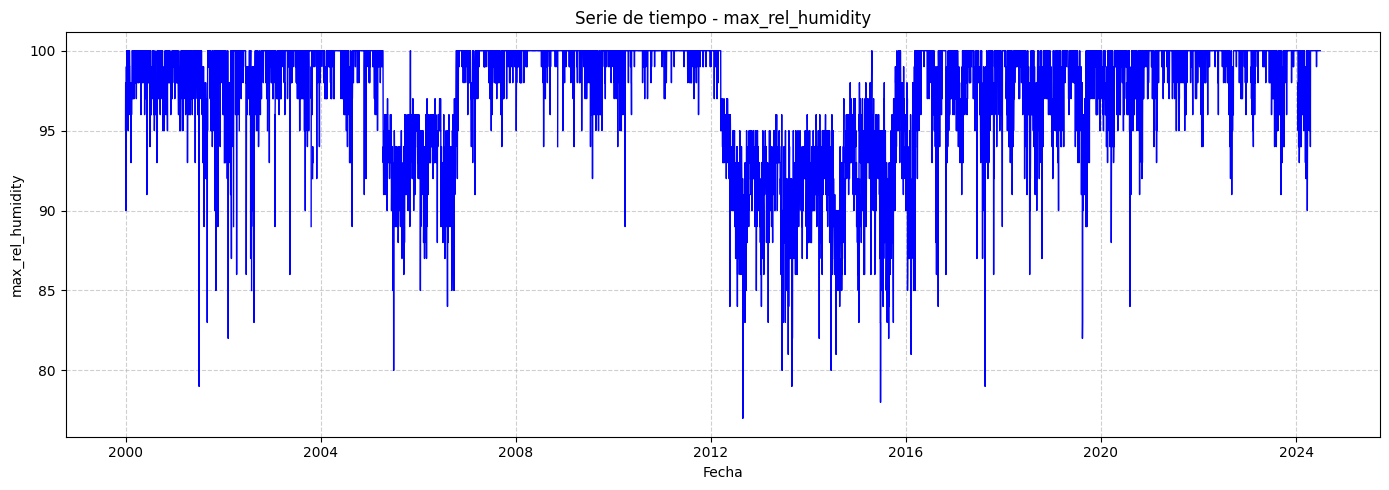

In [ ]:
df["date"] = pd.to_datetime(df["date"])
df = df.sort_values("date") # Tengan en cuenta asegurar el ordenamiento de esta serie de tiempo

# Visualizar la serie de tiempo de precipitación
plt.figure(figsize=(14,5))
plt.plot(df["date"], df["max_rel_humidity"], color="blue", linewidth=1)
plt.title("Serie de tiempo - max_rel_humidity")
plt.xlabel("Fecha")
plt.ylabel("max_rel_humidity")
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

###Radiacion Solar

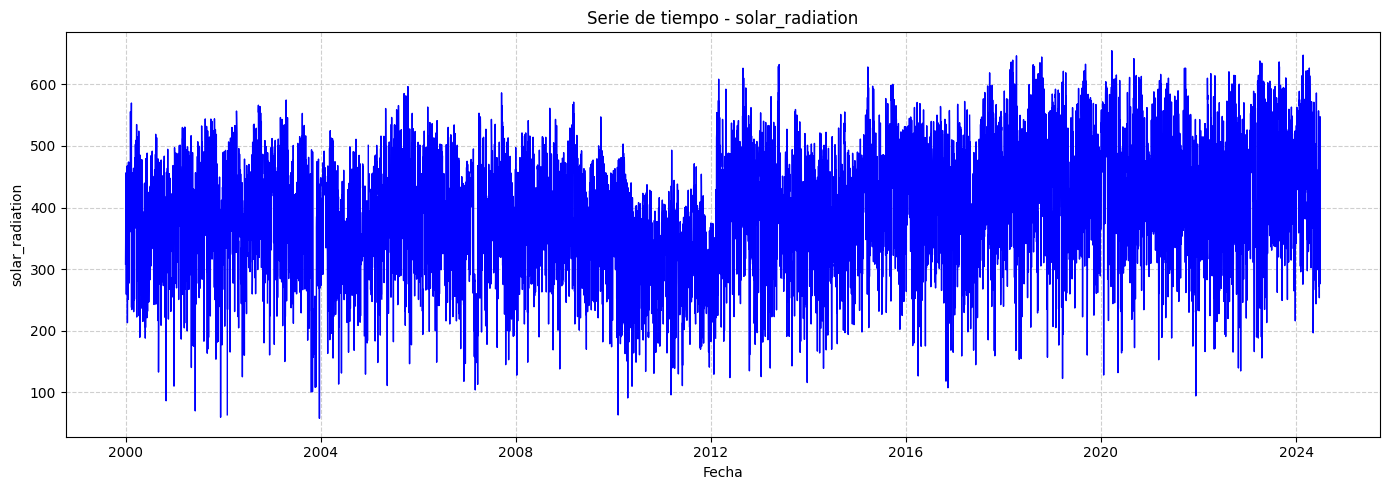

In [ ]:
df["date"] = pd.to_datetime(df["date"])
df = df.sort_values("date") # Tengan en cuenta asegurar el ordenamiento de esta serie de tiempo

# Visualizar la serie de tiempo de precipitación
plt.figure(figsize=(14,5))
plt.plot(df["date"], df["solar_radiation"], color="blue", linewidth=1)
plt.title("Serie de tiempo - solar_radiation")
plt.xlabel("Fecha")
plt.ylabel("solar_radiation")
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

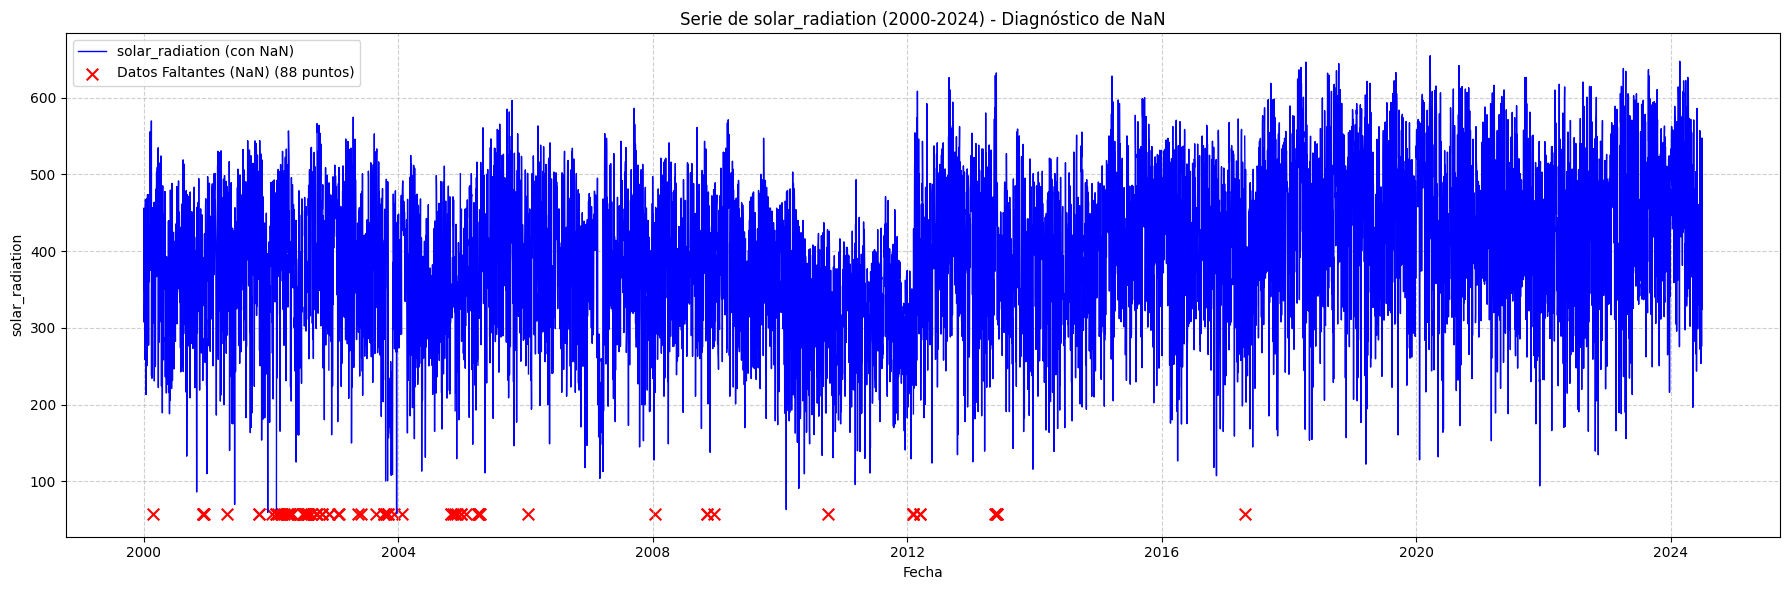

Total de NaN encontrados: 88


In [ ]:
df["date"] = pd.to_datetime(df["date"])
df = df.sort_values("date") # Tengan en cuenta asegurar el ordenamiento de esta serie de tiempo

# --- 1. VISUALIZAR LA SERIE COMPLETA (2000-2024) ---
plt.figure(figsize=(18, 6))

# Ploteamos la serie con los NaN (la línea se romperá donde hay NaN)
plt.plot(df["date"],
         df["solar_radiation"],
         color="blue",
         linewidth=1,
         label="solar_radiation (con NaN)")

# 2. Resaltar todos los puntos Faltantes (NaN)
nan_values = df[df["solar_radiation"].isnull()]

if not nan_values.empty:
    # Usamos el valor mínimo visible para posicionar las marcas rojas,
    # para que no interfieran con la línea.
    min_visible_humidity = df["solar_radiation"].min()

    plt.scatter(nan_values["date"],
                [min_visible_humidity] * len(nan_values),
                color='red',
                marker='x',
                s=70,
                label=f'Datos Faltantes (NaN) ({len(nan_values)} puntos)')
else:
    print("¡No se encontraron NaN en solar_radiation! La serie ya está completa.")


plt.title("Serie de solar_radiation (2000-2024) - Diagnóstico de NaN")
plt.xlabel("Fecha")
plt.ylabel("solar_radiation")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

# 3. Diagnóstico de Fechas Específicas
print(f"Total de NaN encontrados: {nan_values.shape[0]}")

###Evapracion

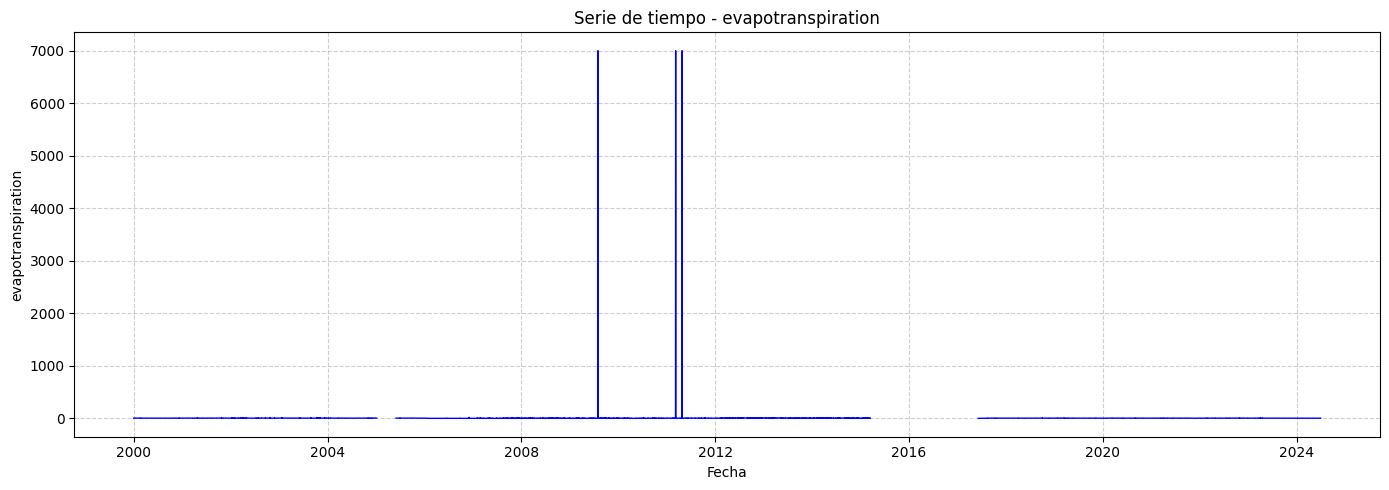

In [ ]:
df["date"] = pd.to_datetime(df["date"])
df = df.sort_values("date") # Tengan en cuenta asegurar el ordenamiento de esta serie de tiempo

# Visualizar la serie de tiempo de precipitación
plt.figure(figsize=(14,5))
plt.plot(df["date"], df["evapotranspiration"], color="blue", linewidth=1)
plt.title("Serie de tiempo - evapotranspiration")
plt.xlabel("Fecha")
plt.ylabel("evapotranspiration")
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

Se debe hacer una exploracion de los periodos que no presentan continuidad para analizar si en esos periodos hay datos o son todos datos no existentes en este se debe buscar el periodo aproximado de 2005 y los datos alredodero del 2016. ademas de revisar si hay datos existente en los espacios observados

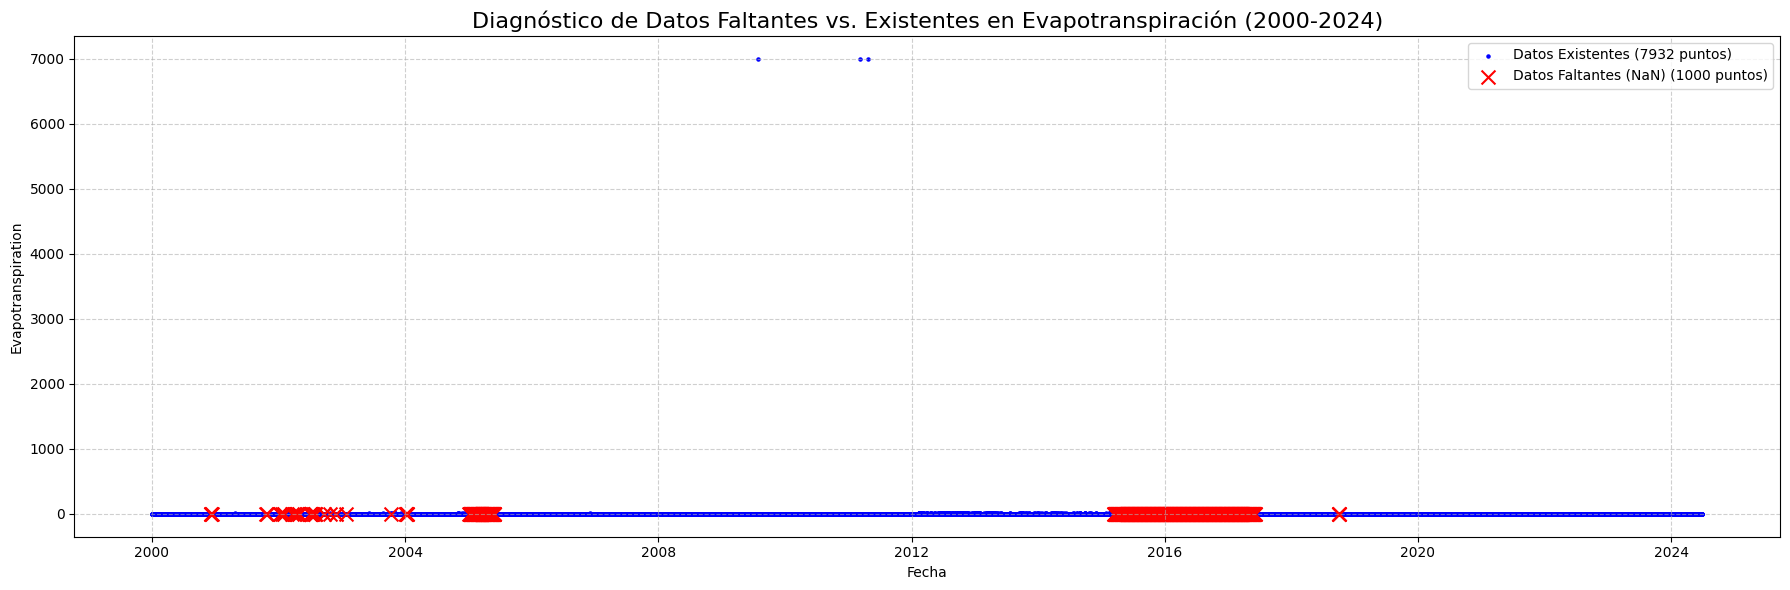

Total de NaN encontrados en ET: 1000


In [ ]:
# --- 1. PREPARAR PUNTOS ---
df["date"] = pd.to_datetime(df["date"])
df = df.sort_values("date")
# Separar los datos en dos grupos: Existentes y Faltantes

# Datos existentes (NO son NaN)
df_existentes = df[df["evapotranspiration"].notnull()].copy()

# Datos faltantes (SÍ son NaN)
df_faltantes = df[df["evapotranspiration"].isnull()].copy()

# 2. VISUALIZAR LA SERIE COMPLETA (2000-2024)
plt.figure(figsize=(18, 6))

# --- PLOT 1: Puntos Existentes (Azules) ---
# Usamos un 'scatter' para ver cada punto individualmente
plt.scatter(df_existentes["date"],
            df_existentes["evapotranspiration"],
            color='blue',
            s=5,
            label=f'Datos Existentes ({len(df_existentes)} puntos)')

# --- PLOT 2: Puntos Faltantes (Rojos) ---
if not df_faltantes.empty:
    # Para visualizar mejor, colocamos las 'X' rojas en la parte inferior del gráfico (en y=0)
    plt.scatter(df_faltantes["date"],
                [0] * len(df_faltantes), # Posicionamos en y=0
                color='red',
                marker='x',
                s=100,
                label=f'Datos Faltantes (NaN) ({len(df_faltantes)} puntos)')
else:
    print("¡No se encontraron NaN en evapotranspiration!")


plt.title("Diagnóstico de Datos Faltantes vs. Existentes en Evapotranspiración (2000-2024)", fontsize=16)
plt.xlabel("Fecha")
plt.ylabel("Evapotranspiration")
plt.legend(loc='upper right')
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

# 3. Diagnóstico de Fechas Específicas
print(f"Total de NaN encontrados en ET: {df_faltantes.shape[0]}")

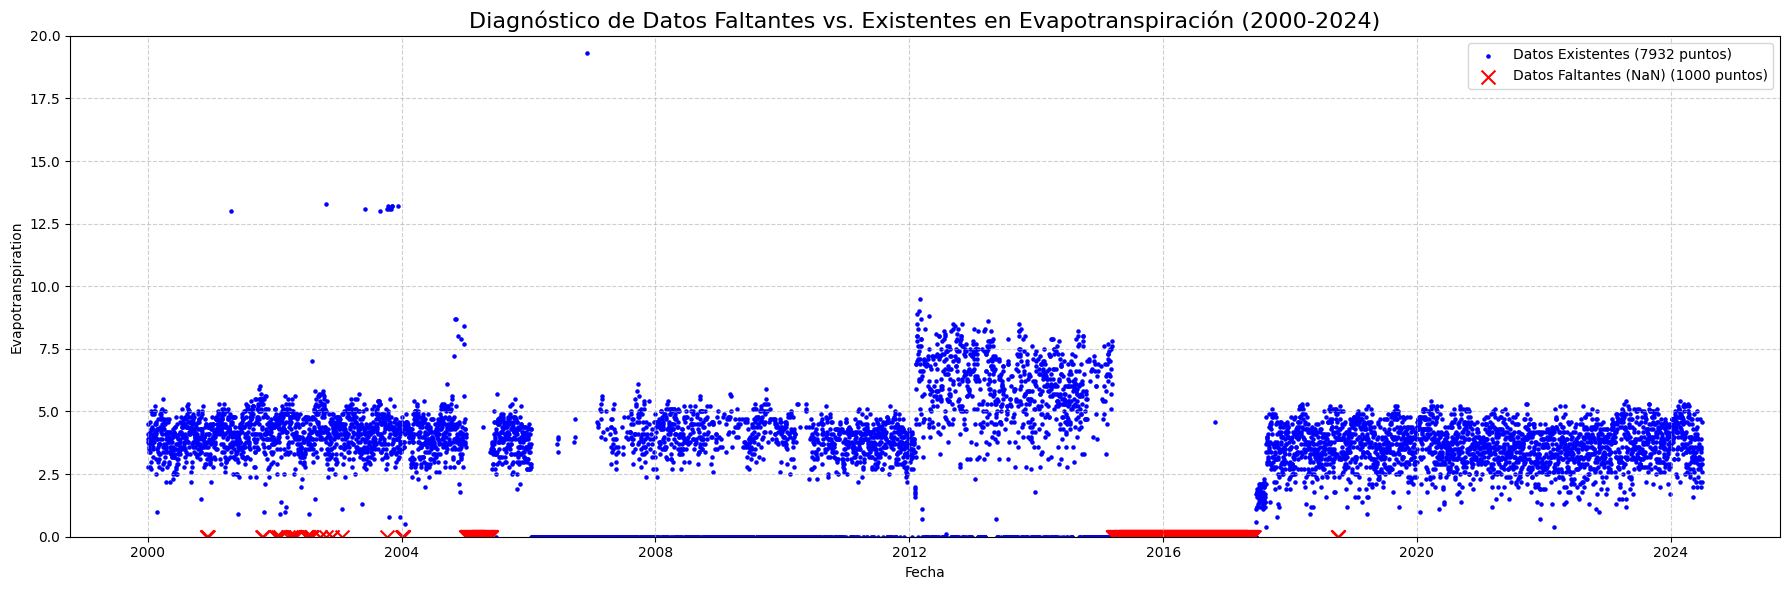

Total de NaN encontrados en ET: 1000


In [ ]:
# --- 1. PREPARAR PUNTOS ---
df["date"] = pd.to_datetime(df["date"])
df = df.sort_values("date")
# Separar los datos en dos grupos: Existentes y Faltantes

# Datos existentes (NO son NaN)
df_existentes = df[df["evapotranspiration"].notnull()].copy()

# Datos faltantes (SÍ son NaN)
df_faltantes = df[df["evapotranspiration"].isnull()].copy()

# 2. VISUALIZAR LA SERIE COMPLETA (2000-2024)
plt.figure(figsize=(18, 6))

# --- PLOT 1: Puntos Existentes (Azules) ---
# Usamos un 'scatter' para ver cada punto individualmente
plt.scatter(df_existentes["date"],
            df_existentes["evapotranspiration"],
            color='blue',
            s=5,
            label=f'Datos Existentes ({len(df_existentes)} puntos)')

# --- PLOT 2: Puntos Faltantes (Rojos) ---
if not df_faltantes.empty:
    # Para visualizar mejor, colocamos las 'X' rojas en la parte inferior del gráfico (en y=0)
    plt.scatter(df_faltantes["date"],
                [0] * len(df_faltantes), # Posicionamos en y=0
                color='red',
                marker='x',
                s=100,
                label=f'Datos Faltantes (NaN) ({len(df_faltantes)} puntos)')
else:
    print("¡No se encontraron NaN en evapotranspiration!")


# --- ¡CORRECCIÓN CLAVE AQUÍ! ---
# Limitar el Eje Y para ignorar los outliers extremos (>25)
plt.ylim(0, 20)


plt.title("Diagnóstico de Datos Faltantes vs. Existentes en Evapotranspiración (2000-2024)", fontsize=16)
plt.xlabel("Fecha")
plt.ylabel("Evapotranspiration")
plt.legend(loc='upper right')
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

# 3. Diagnóstico de Fechas Específicas
print(f"Total de NaN encontrados en ET: {df_faltantes.shape[0]}")

se deben revisar los periosd del 2001 al 2003, asi como los del 2005 al 2006, y por ultomo delo del 2015 al 2018 para observar el comportamiento de los datos y estimar que metodi de imputacion es adecuado para la ella

In [ ]:
df["evapotranspiration"].describe()

count    7932.000000
mean        5.993633
std       136.046619
min         0.000000
25%         2.700000
50%         3.800000
75%         4.500000
max      6999.000000
Name: evapotranspiration, dtype: float64

Además, revisando los datos, se considera que el valor máximo de la serie sería un valor atípico muy gigantesco, por lo cual se busca literatura para comprender si este valor es posible en la Tierra. Si no, se deberá ejecutar otro tipo de imputación para llevar el valor más a la realidad.

La evaporación en la Tierra históricamente nunca ha llegado al valor máximo ejecutado, por lo cual se estima que debe ser un error en digitación o de sensor. Por lo tanto, se tomará como evaporación máxima el dato que estám por debajo de 20 , ya que es un dato válido para ciertas zonas del mundo, como en el Medio Oriente, el norte de África y partes de Australia y América.

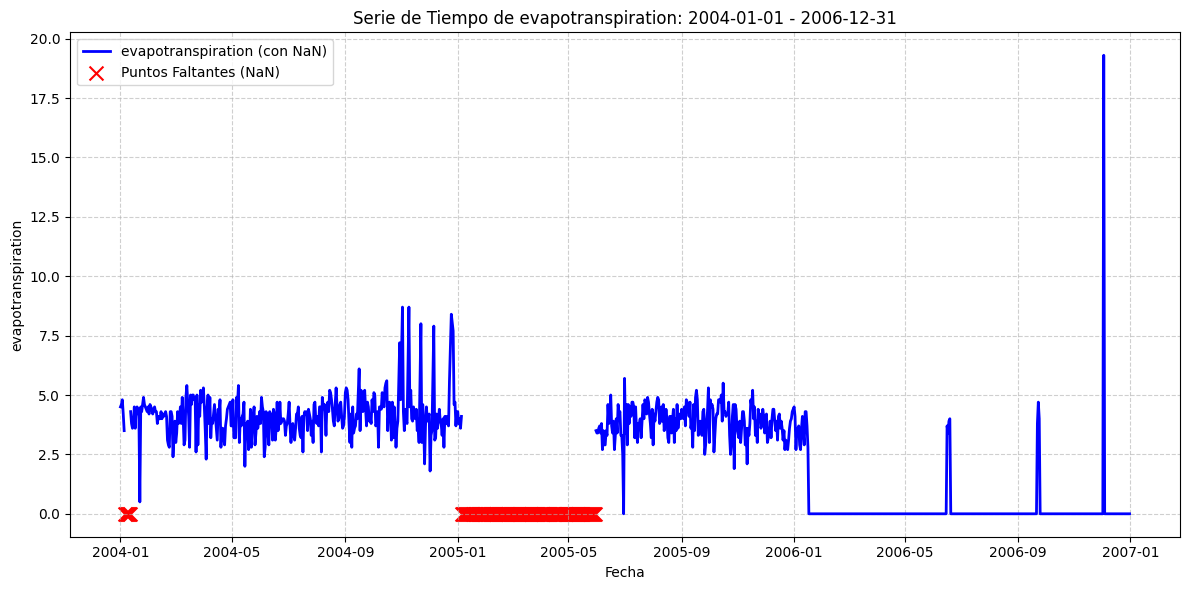

Total de NaN en este período: 145


In [ ]:
df["date"] = pd.to_datetime(df["date"])
df = df.sort_values("date") #

# --- 1. FILTRAR EL PERÍODO DE INTERÉS (2004-2006) ---
start_date = '2004-01-01'
end_date = '2006-12-31'

df_periodo = df[(df["date"] >= start_date) & (df["date"] <= end_date)].copy()

# 2. Visualizar la Serie de Tiempo Normal (donde Pandas crea los huecos)
plt.figure(figsize=(12, 6))

# Ploteamos la serie con los NaN (la línea se romperá donde hay NaN)
plt.plot(df_periodo["date"],
         df_periodo["evapotranspiration"],
         color="blue",
         linewidth=2,
         label="evapotranspiration (con NaN)")

# 3. Resaltar los puntos Faltantes (NaN) en este período
nan_values = df_periodo[df_periodo["evapotranspiration"].isnull()]

# Ploteamos esos NaN como puntos grandes y rojos en el eje X
if not nan_values.empty:
    # Usamos el valor mínimo visible para posicionar las marcas rojas
    min_visible_humidity = df_periodo["evapotranspiration"].min()

    plt.scatter(nan_values["date"],
                [min_visible_humidity] * len(nan_values),
                color='red',
                marker='x',
                s=100,
                label='Puntos Faltantes (NaN)')
else:
    print(f"No se encontraron NaN en evapotranspirationentre {start_date} y {end_date}. Visualizando la serie completa.")


plt.title(f"Serie de Tiempo de evapotranspiration: {start_date} - {end_date}")
plt.xlabel("Fecha")
plt.ylabel("evapotranspiration")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

# 4. Diagnóstico final
print(f"Total de NaN en este período: {nan_values.shape[0]}")

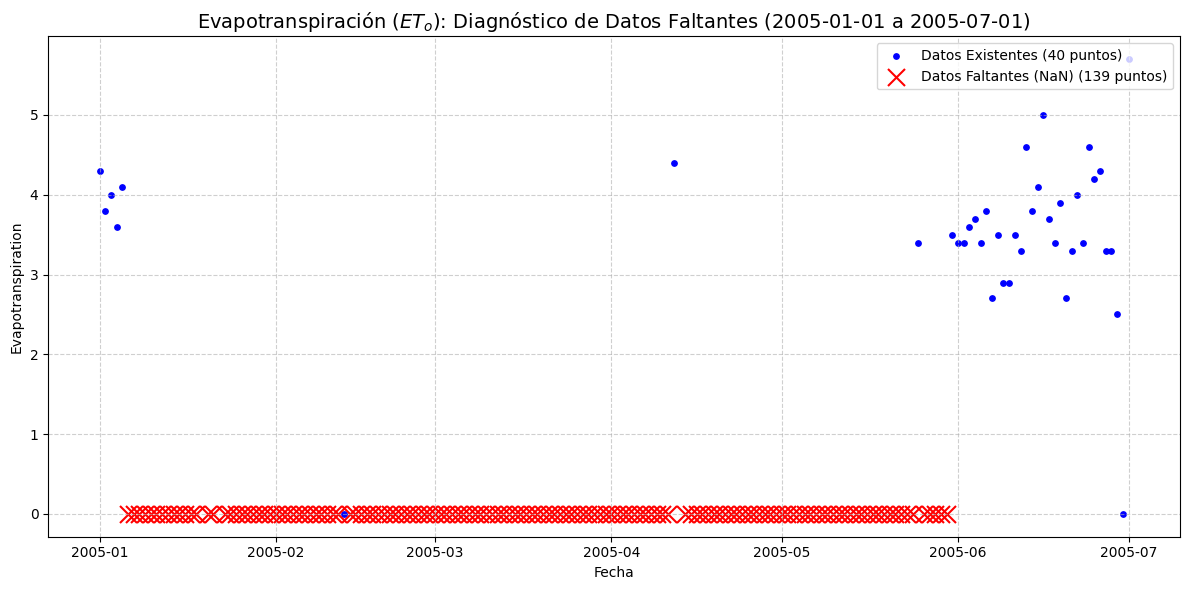

Total de NaN encontrados en ET en este período: 139


In [ ]:
df["date"] = pd.to_datetime(df["date"])
df = df.sort_values("date") #
# --- 1. FILTRAR EL PERÍODO DE INTERÉS ---
start_date = '2005-01-01'
end_date = '2005-07-01'

# Crear un DataFrame filtrado para el período
df_periodo = df[(df["date"] >= start_date) & (df["date"] <= end_date)].copy()

# --- 2. PREPARAR PUNTOS FILTRADOS ---
# Datos existentes (NO son NaN) en el período
df_existentes = df_periodo[df_periodo["evapotranspiration"].notnull()].copy()

# Datos faltantes (SÍ son NaN) en el período
df_faltantes = df_periodo[df_periodo["evapotranspiration"].isnull()].copy()

# 3. VISUALIZAR LA SERIE EN EL PERÍODO FILTRADO
plt.figure(figsize=(12, 6))

# --- PLOT 1: Puntos Existentes (Azules) ---
plt.scatter(df_existentes["date"],
            df_existentes["evapotranspiration"],
            color='blue',
            s=15, # Aumentamos el tamaño para mejor visibilidad
            label=f'Datos Existentes ({len(df_existentes)} puntos)')

# --- PLOT 2: Puntos Faltantes (Rojos) ---
if not df_faltantes.empty:
    # Posicionamos las 'X' rojas en y=0
    plt.scatter(df_faltantes["date"],
                [0] * len(df_faltantes),
                color='red',
                marker='x',
                s=150, # Aumentamos el tamaño
                label=f'Datos Faltantes (NaN) ({len(df_faltantes)} puntos)')
else:
    print(f"¡No se encontraron NaN en evapotranspiration en el período {start_date} a {end_date}!")


plt.title(f"Evapotranspiración ($ET_o$): Diagnóstico de Datos Faltantes ({start_date} a {end_date})", fontsize=14)
plt.xlabel("Fecha")
plt.ylabel("Evapotranspiration")
plt.legend(loc='upper right')
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

# 4. Diagnóstico de Fechas Específicas
print(f"Total de NaN encontrados en ET en este período: {df_faltantes.shape[0]}")

Esta parte de la seria presenta demasiados datos vacios, lo que genera un recto para la imputacion

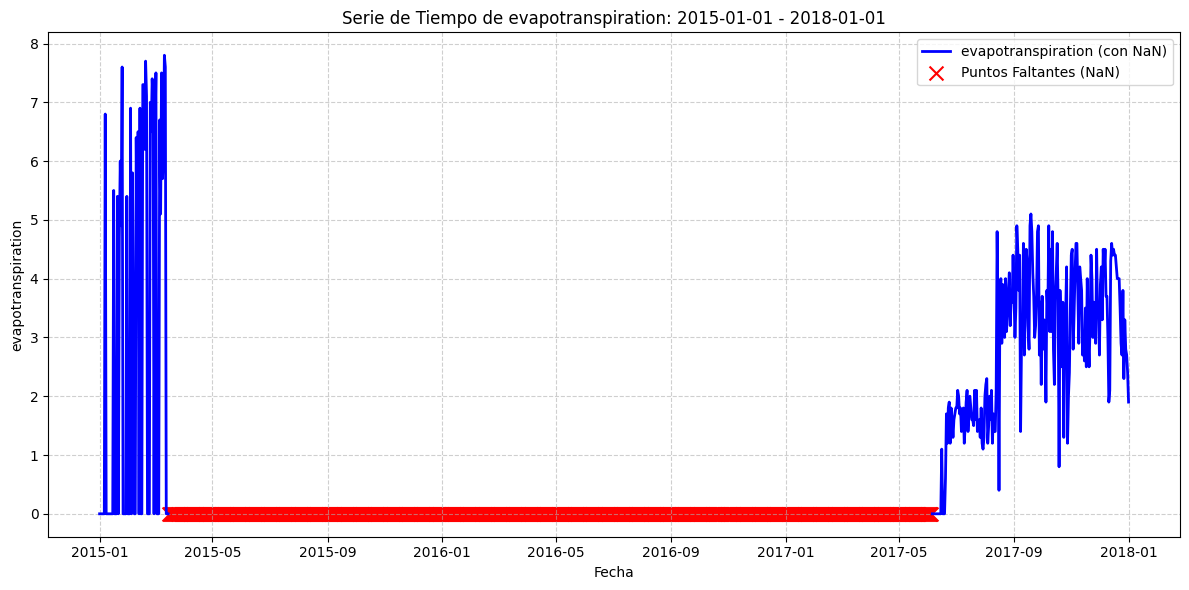

Total de NaN en este período: 812


In [ ]:
df["date"] = pd.to_datetime(df["date"])
df = df.sort_values("date") #

# --- 1. FILTRAR EL PERÍODO DE INTERÉS (2004-2006) ---
start_date = '2015-01-01'
end_date = '2018-01-01'

df_periodo = df[(df["date"] >= start_date) & (df["date"] <= end_date)].copy()

# 2. Visualizar la Serie de Tiempo Normal (donde Pandas crea los huecos)
plt.figure(figsize=(12, 6))

# Ploteamos la serie con los NaN (la línea se romperá donde hay NaN)
plt.plot(df_periodo["date"],
         df_periodo["evapotranspiration"],
         color="blue",
         linewidth=2,
         label="evapotranspiration (con NaN)")

# 3. Resaltar los puntos Faltantes (NaN) en este período
nan_values = df_periodo[df_periodo["evapotranspiration"].isnull()]

# Ploteamos esos NaN como puntos grandes y rojos en el eje X
if not nan_values.empty:
    # Usamos el valor mínimo visible para posicionar las marcas rojas
    min_visible_humidity = df_periodo["evapotranspiration"].min()

    plt.scatter(nan_values["date"],
                [min_visible_humidity] * len(nan_values),
                color='red',
                marker='x',
                s=100,
                label='Puntos Faltantes (NaN)')
else:
    print(f"No se encontraron NaN en evapotranspirationentre {start_date} y {end_date}. Visualizando la serie completa.")


plt.title(f"Serie de Tiempo de evapotranspiration: {start_date} - {end_date}")
plt.xlabel("Fecha")
plt.ylabel("evapotranspiration")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

# 4. Diagnóstico final
print(f"Total de NaN en este período: {nan_values.shape[0]}")

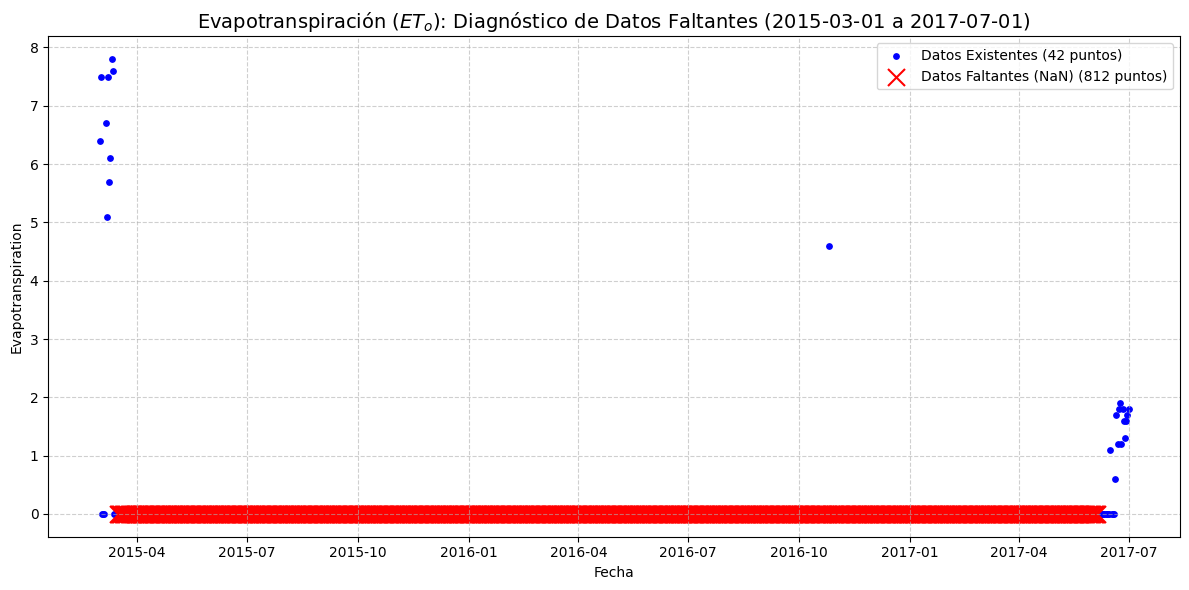

Total de NaN encontrados en ET en este período: 812


In [ ]:
df["date"] = pd.to_datetime(df["date"])
df = df.sort_values("date") #
# --- 1. FILTRAR EL PERÍODO DE INTERÉS ---
start_date = '2015-03-01'
end_date = '2017-07-01'

# Crear un DataFrame filtrado para el período
df_periodo = df[(df["date"] >= start_date) & (df["date"] <= end_date)].copy()

# --- 2. PREPARAR PUNTOS FILTRADOS ---
# Datos existentes (NO son NaN) en el período
df_existentes = df_periodo[df_periodo["evapotranspiration"].notnull()].copy()

# Datos faltantes (SÍ son NaN) en el período
df_faltantes = df_periodo[df_periodo["evapotranspiration"].isnull()].copy()

# 3. VISUALIZAR LA SERIE EN EL PERÍODO FILTRADO
plt.figure(figsize=(12, 6))

# --- PLOT 1: Puntos Existentes (Azules) ---
plt.scatter(df_existentes["date"],
            df_existentes["evapotranspiration"],
            color='blue',
            s=15, # Aumentamos el tamaño para mejor visibilidad
            label=f'Datos Existentes ({len(df_existentes)} puntos)')

# --- PLOT 2: Puntos Faltantes (Rojos) ---
if not df_faltantes.empty:
    # Posicionamos las 'X' rojas en y=0
    plt.scatter(df_faltantes["date"],
                [0] * len(df_faltantes),
                color='red',
                marker='x',
                s=150, # Aumentamos el tamaño
                label=f'Datos Faltantes (NaN) ({len(df_faltantes)} puntos)')
else:
    print(f"¡No se encontraron NaN en evapotranspiration en el período {start_date} a {end_date}!")


plt.title(f"Evapotranspiración ($ET_o$): Diagnóstico de Datos Faltantes ({start_date} a {end_date})", fontsize=14)
plt.xlabel("Fecha")
plt.ylabel("Evapotranspiration")
plt.legend(loc='upper right')
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

# 4. Diagnóstico de Fechas Específicas
print(f"Total de NaN encontrados en ET en este período: {df_faltantes.shape[0]}")

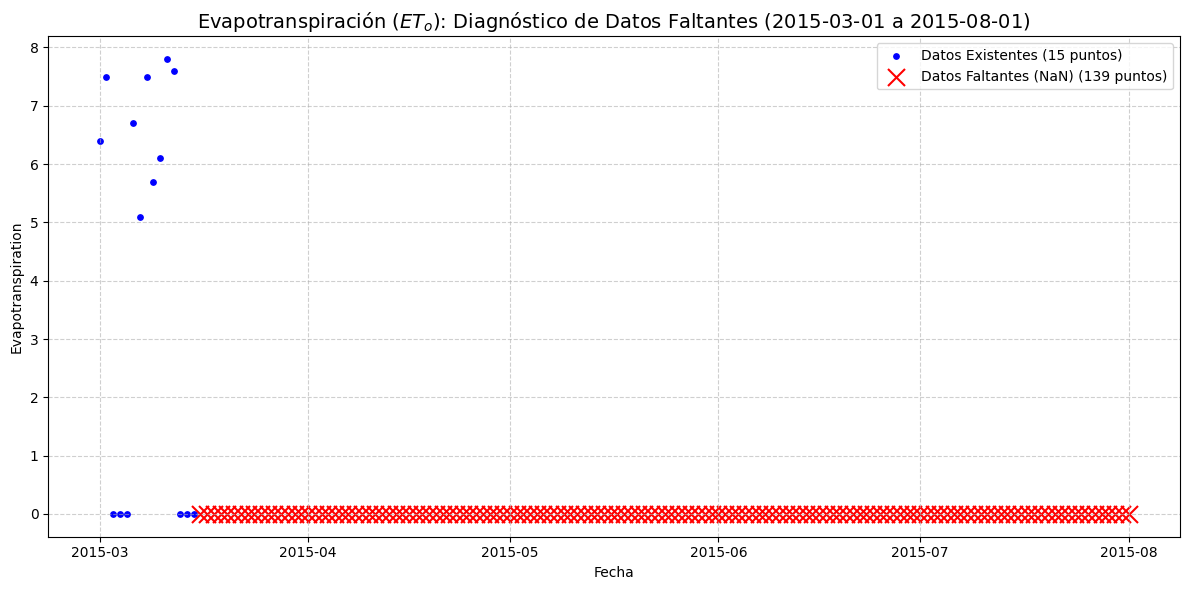

Total de NaN encontrados en ET en este período: 139


In [ ]:
df["date"] = pd.to_datetime(df["date"])
df = df.sort_values("date") #
# --- 1. FILTRAR EL PERÍODO DE INTERÉS ---
start_date = '2015-03-01'
end_date = '2015-08-01'

# Crear un DataFrame filtrado para el período
df_periodo = df[(df["date"] >= start_date) & (df["date"] <= end_date)].copy()

# --- 2. PREPARAR PUNTOS FILTRADOS ---
# Datos existentes (NO son NaN) en el período
df_existentes = df_periodo[df_periodo["evapotranspiration"].notnull()].copy()

# Datos faltantes (SÍ son NaN) en el período
df_faltantes = df_periodo[df_periodo["evapotranspiration"].isnull()].copy()

# 3. VISUALIZAR LA SERIE EN EL PERÍODO FILTRADO
plt.figure(figsize=(12, 6))

# --- PLOT 1: Puntos Existentes (Azules) ---
plt.scatter(df_existentes["date"],
            df_existentes["evapotranspiration"],
            color='blue',
            s=15, # Aumentamos el tamaño para mejor visibilidad
            label=f'Datos Existentes ({len(df_existentes)} puntos)')

# --- PLOT 2: Puntos Faltantes (Rojos) ---
if not df_faltantes.empty:
    # Posicionamos las 'X' rojas en y=0
    plt.scatter(df_faltantes["date"],
                [0] * len(df_faltantes),
                color='red',
                marker='x',
                s=150, # Aumentamos el tamaño
                label=f'Datos Faltantes (NaN) ({len(df_faltantes)} puntos)')
else:
    print(f"¡No se encontraron NaN en evapotranspiration en el período {start_date} a {end_date}!")


plt.title(f"Evapotranspiración ($ET_o$): Diagnóstico de Datos Faltantes ({start_date} a {end_date})", fontsize=14)
plt.xlabel("Fecha")
plt.ylabel("Evapotranspiration")
plt.legend(loc='upper right')
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

# 4. Diagnóstico de Fechas Específicas
print(f"Total de NaN encontrados en ET en este período: {df_faltantes.shape[0]}")

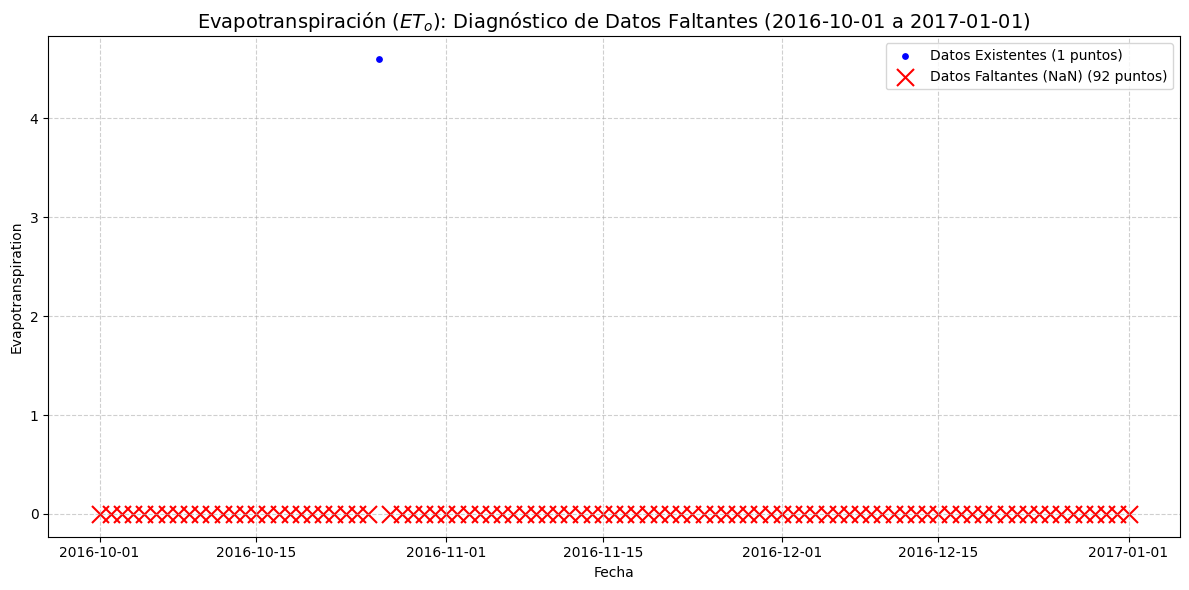

Total de NaN encontrados en ET en este período: 92


In [ ]:
df["date"] = pd.to_datetime(df["date"])
df = df.sort_values("date") #
# --- 1. FILTRAR EL PERÍODO DE INTERÉS ---
start_date = '2016-10-01'
end_date = '2017-01-01'

# Crear un DataFrame filtrado para el período
df_periodo = df[(df["date"] >= start_date) & (df["date"] <= end_date)].copy()

# --- 2. PREPARAR PUNTOS FILTRADOS ---
# Datos existentes (NO son NaN) en el período
df_existentes = df_periodo[df_periodo["evapotranspiration"].notnull()].copy()

# Datos faltantes (SÍ son NaN) en el período
df_faltantes = df_periodo[df_periodo["evapotranspiration"].isnull()].copy()

# 3. VISUALIZAR LA SERIE EN EL PERÍODO FILTRADO
plt.figure(figsize=(12, 6))

# --- PLOT 1: Puntos Existentes (Azules) ---
plt.scatter(df_existentes["date"],
            df_existentes["evapotranspiration"],
            color='blue',
            s=15, # Aumentamos el tamaño para mejor visibilidad
            label=f'Datos Existentes ({len(df_existentes)} puntos)')

# --- PLOT 2: Puntos Faltantes (Rojos) ---
if not df_faltantes.empty:
    # Posicionamos las 'X' rojas en y=0
    plt.scatter(df_faltantes["date"],
                [0] * len(df_faltantes),
                color='red',
                marker='x',
                s=150, # Aumentamos el tamaño
                label=f'Datos Faltantes (NaN) ({len(df_faltantes)} puntos)')
else:
    print(f"¡No se encontraron NaN en evapotranspiration en el período {start_date} a {end_date}!")


plt.title(f"Evapotranspiración ($ET_o$): Diagnóstico de Datos Faltantes ({start_date} a {end_date})", fontsize=14)
plt.xlabel("Fecha")
plt.ylabel("Evapotranspiration")
plt.legend(loc='upper right')
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

# 4. Diagnóstico de Fechas Específicas
print(f"Total de NaN encontrados en ET en este período: {df_faltantes.shape[0]}")

En este caso de deberan imputar con valores en base a meses anterioes y posterios a los periodos que presentan un amplio rango, incluso es posble tomar datos de años anteriores por el mismo periodo mensual

## Visualicemos tendencias

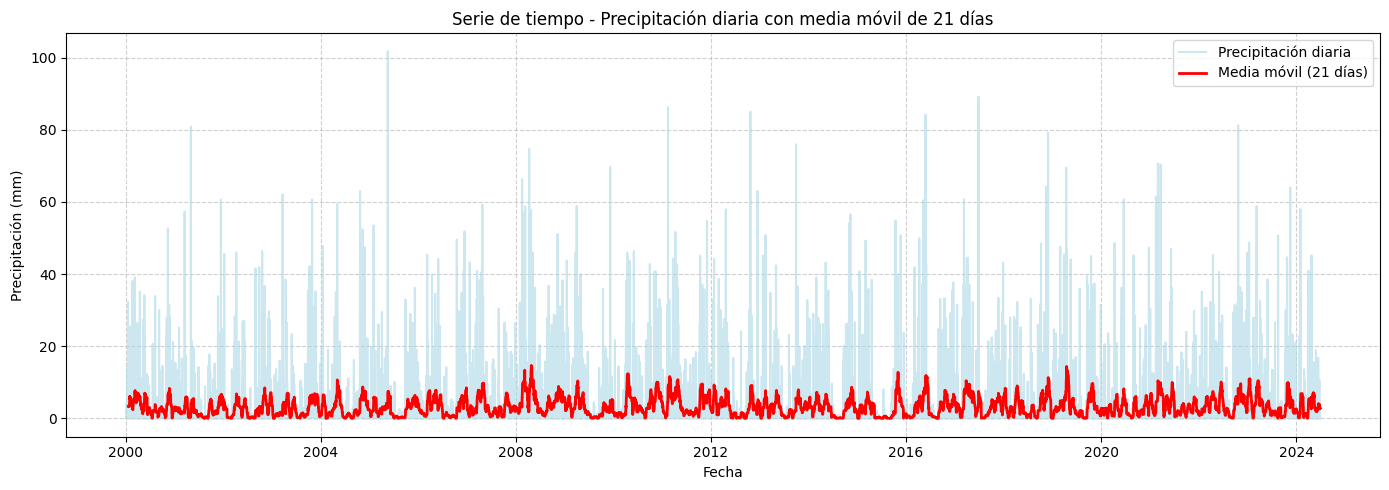

In [ ]:
# Calcular media móvil de 21 días
df["precipitation_ma21"] = df["precipitation"].rolling(window=21).mean()

# Graficar serie original vs media móvil
plt.figure(figsize=(14,5))
plt.plot(df["date"], df["precipitation"], color="lightblue", alpha=0.6, label="Precipitación diaria")
plt.plot(df["date"], df["precipitation_ma21"], color="red", linewidth=2, label="Media móvil (21 días)")
plt.title("Serie de tiempo - Precipitación diaria con media móvil de 21 días")
plt.xlabel("Fecha")
plt.ylabel("Precipitación (mm)")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

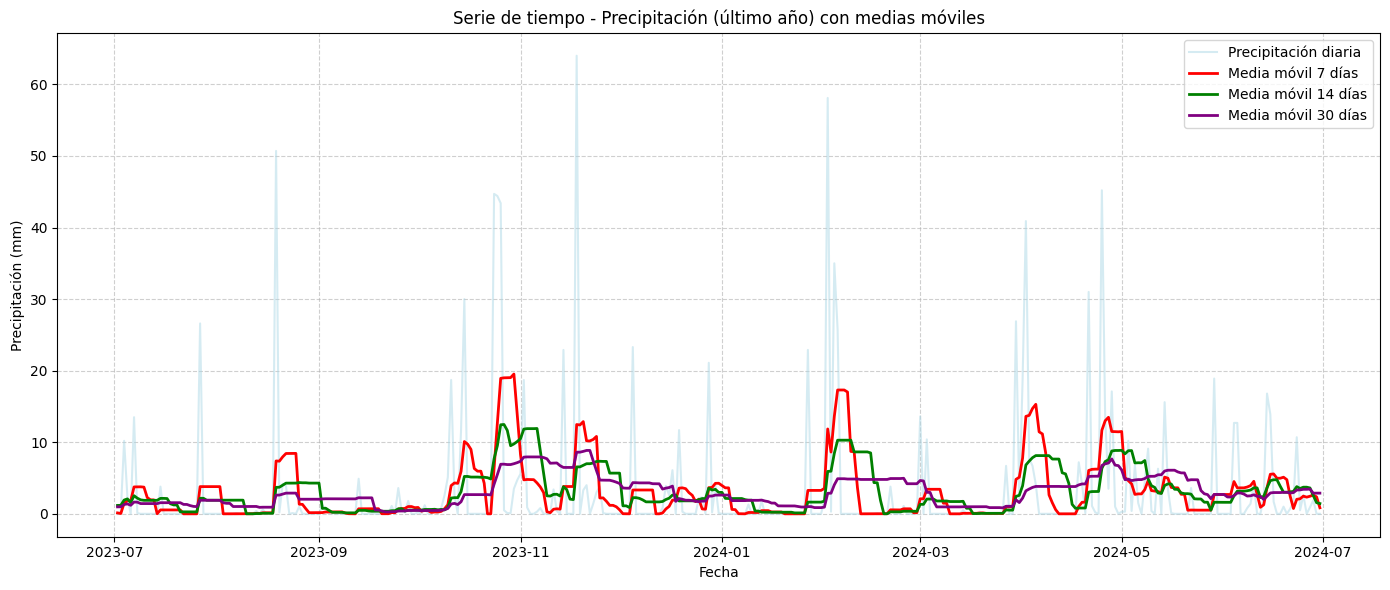

In [ ]:
# Calcular medias móviles
df["precipitation_ma7"] = df["precipitation"].rolling(window=7).mean()
df["precipitation_ma14"] = df["precipitation"].rolling(window=14).mean()
df["precipitation_ma30"] = df["precipitation"].rolling(window=30).mean()

# Filtrar último año (365 días)
df_last_year = df.tail(365)

# Graficar serie original y suavizadas
plt.figure(figsize=(14,6))
plt.plot(df_last_year["date"], df_last_year["precipitation"], color="lightblue", alpha=0.5, label="Precipitación diaria")
plt.plot(df_last_year["date"], df_last_year["precipitation_ma7"], color="red", linewidth=2, label="Media móvil 7 días")
plt.plot(df_last_year["date"], df_last_year["precipitation_ma14"], color="green", linewidth=2, label="Media móvil 14 días")
plt.plot(df_last_year["date"], df_last_year["precipitation_ma30"], color="purple", linewidth=2, label="Media móvil 30 días")

plt.title("Serie de tiempo - Precipitación (último año) con medias móviles")
plt.xlabel("Fecha")
plt.ylabel("Precipitación (mm)")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

**Importante** -> Conclusiones sobre el EDA

*Ejemplo*

1. La precipitación diaria muestra una alta variabilidad, con picos muy marcados que alcanzan hasta más de 60 mm en un solo día, lo que refleja eventos de lluvia intensa poco frecuentes pero significativos.

2. La media móvil de 7 días (rojo) suaviza ligeramente la serie y permite identificar con mayor claridad los periodos de lluvia continua, destacando episodios recurrentes hacia finales de 2023 y en los meses de marzo y mayo de 2024.

3. La media móvil de 14 días (verde) reduce aún más la variabilidad, resaltando ciclos más amplios de mayor o menor precipitación, útil para observar tendencias quincenales.

4. La media móvil de 30 días (morado) elimina gran parte del ruido, mostrando la tendencia general: se observan periodos secos prolongados intercalados con fases de incremento en las lluvias, lo que podría relacionarse con la estacionalidad climática.

**Esto nos ayudará a determinar los lags y secuence_lenght para los modelos MLP-RNN**

## Exploremos relaciones

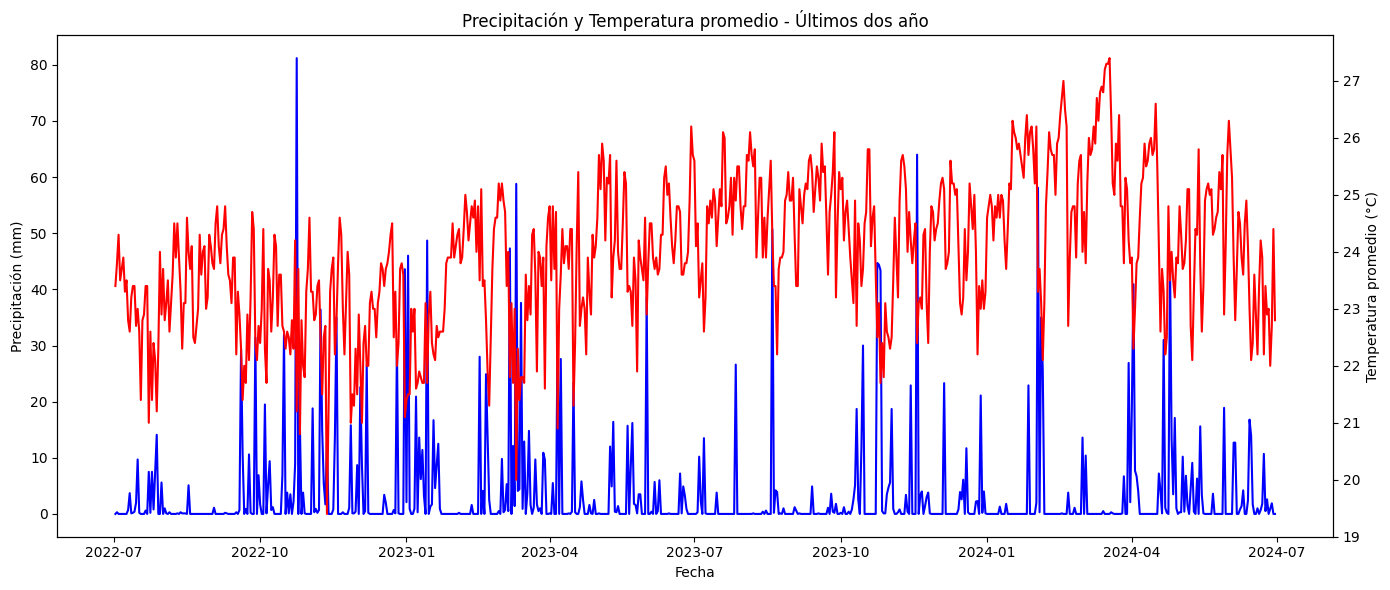

In [ ]:
# Filtrar últimos dos año
df_last_year = df.tail(730)

# Crear figura y eje
fig, ax1 = plt.subplots(figsize=(14,6))

# Primer eje Y: Precipitación
color = "blue"
ax1.set_xlabel("Fecha")
ax1.set_ylabel("Precipitación (mm)")
ax1.plot(df_last_year["date"], df_last_year["precipitation"], color=color, linewidth=1.5, label="Precipitación")
ax1.tick_params(axis="y")

# Segundo eje Y: Temperatura promedio
ax2 = ax1.twinx()
color = "red"
ax2.set_ylabel("Temperatura promedio (°C)")
ax2.plot(df_last_year["date"], df_last_year["avg_temp"], color=color, linewidth=1.5, label="Temperatura promedio")
ax2.tick_params(axis="y")

# Título y ajustes
plt.title("Precipitación y Temperatura promedio - Últimos dos año")
fig.tight_layout()
plt.show()

## Analicemos las correlaciones

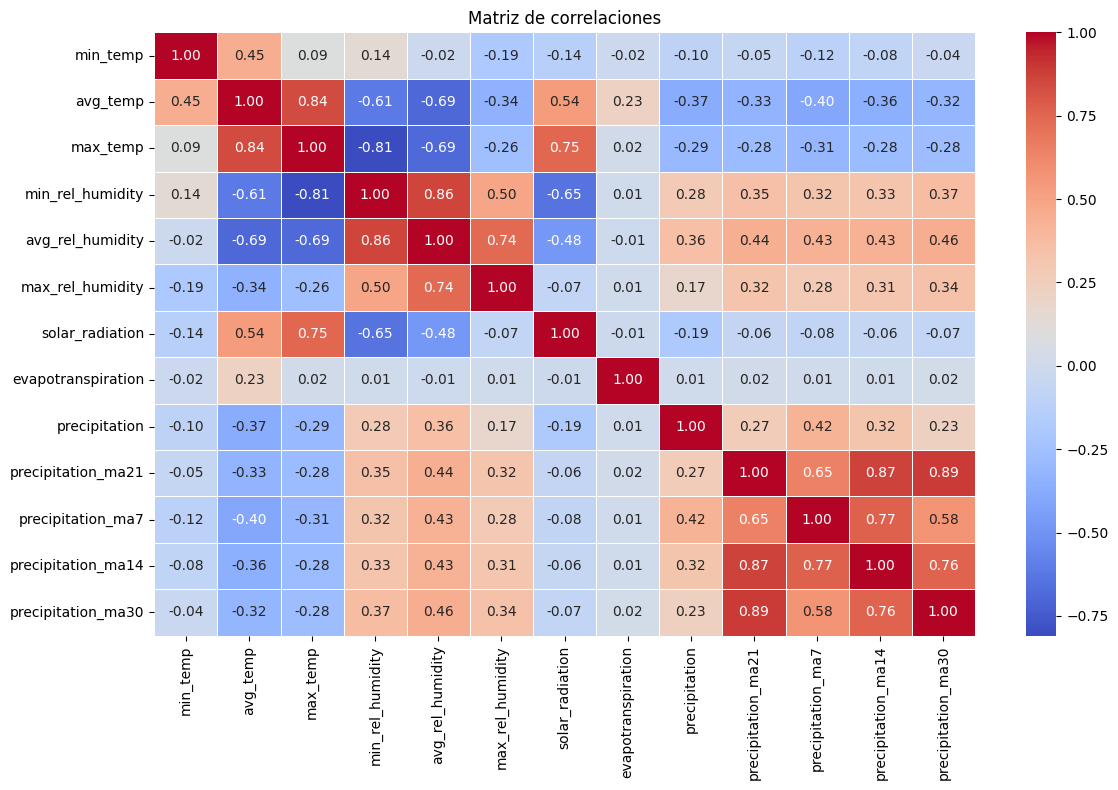

In [ ]:
import seaborn as sns
# Asegurar que la columna date no entre en el cálculo
df_corr = df.drop(columns=["date", "year"])

# Calcular la matriz de correlaciones
corr_matrix = df_corr.corr()

# Visualizar con un mapa de calor
plt.figure(figsize=(12,8))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Matriz de correlaciones")
plt.tight_layout()
plt.show()

**Importante** -> Explorar bien los datos, tomar nota y extraer conclusiones, esto servirá de base para definir las arquitecturas de carga de datos para MLP, RNN (lags, secuencia)

In [ ]:
df

date  min_temp  avg_temp  max_temp  min_rel_humidity  \
0    2000-01-01      20.1      23.1      27.5              57.0   
1    2000-01-02      19.2      22.0      26.7              58.0   
2    2000-01-03      18.0      21.7      28.8              51.0   
3    2000-01-04      17.8      21.9      27.1              50.0   
4    2000-01-05      19.0      22.3      27.4              51.0   
...         ...       ...       ...       ...               ...   
8927 2024-06-26      19.5      23.0      29.1              58.0   
8928 2024-06-27      20.2      22.0      27.9              66.0   
8929 2024-06-28      18.8      22.7      28.4              59.0   
8930 2024-06-29      20.2      24.4      31.0              51.0   
8931 2024-06-30      19.5      22.8      28.9              59.0   

      avg_rel_humidity  max_rel_humidity  solar_radiation  evapotranspiration  \
0                 77.0              95.0            308.1                 2.8   
1                 82.0              98.0            343.1                 4.1   
2                 80.0              98.0            456.1                 4.5   
3                 74.0              90.0            391.5                 3.8   
4                 76.0              95.0            348.4                 3.9   
...                ...               ...              ...                 ...   
8927              87.0             100.0            358.8                 2.9   
8928              92.0             100.0            276.0                 2.2   
8929              88.0             100.0            379.5                 3.1   
8930              81.0             100.0            547.2                 4.6   
8931              87.0             100.0            324.7                 2.6   

      precipitation  year  precipitation_ma21  precipitation_ma7  \
0               0.0  2000                 NaN                NaN   
1               0.0  2000                 NaN                NaN   
2               2.1  2000                 NaN                NaN   
3               0.0  2000                 NaN                NaN   
4               0.0  2000                 NaN                NaN   
...             ...   ...                 ...                ...   
8927            0.0  2024            2.785714           2.328571   
8928            0.9  2024            2.828571           2.457143   
8929            1.9  2024            2.919048           2.628571   
8930            0.0  2024            2.880952           2.371429   
8931            0.0  2024            2.814286           0.842857   

      precipitation_ma14  precipitation_ma30  
0                    NaN                 NaN  
1                    NaN                 NaN  
2                    NaN                 NaN  
3                    NaN                 NaN  
4                    NaN                 NaN  
...                  ...                 ...  
8927            3.721429            3.426667  
8928            3.614286            3.456667  
8929            2.550000            2.890000  
8930            1.557143            2.890000  
8931            1.435714            2.890000  

[8932 rows x 15 columns]

##imputacion de datos

# Parámetros

In [ ]:
sequence_length = 5
TARGET_COLUMN = 'precipitation'

# División temporal (train/val)

In [ ]:
# Contar registros por año
counts_per_year = df.groupby(df["date"].dt.year).size()

# Calcular acumulado por año (cumsum)
cumsum_per_year = counts_per_year.cumsum()

# Mostrar resultado
print(cumsum_per_year)

date
2000     366
2001     731
2002    1096
2003    1461
2004    1820
2005    2182
2006    2547
2007    2912
2008    3275
2009    3640
2010    4003
2011    4368
2012    4734
2013    5099
2014    5463
2015    5828
2016    6194
2017    6559
2018    6924
2019    7289
2020    7655
2021    8020
2022    8385
2023    8750
2024    8932
dtype: int64


In [ ]:
# Convertir a porcentaje
cumsum_perc = (cumsum_per_year / cumsum_per_year.iloc[-1]) * 100

# Mostrar resultado
print(cumsum_perc)

date
2000      4.097627
2001      8.184057
2002     12.270488
2003     16.356919
2004     20.376176
2005     24.429019
2006     28.515450
2007     32.601881
2008     36.665920
2009     40.752351
2010     44.816391
2011     48.902821
2012     53.000448
2013     57.086879
2014     61.162114
2015     65.248545
2016     69.346171
2017     73.432602
2018     77.519033
2019     81.605464
2020     85.703090
2021     89.789521
2022     93.875952
2023     97.962382
2024    100.000000
dtype: float64


In [ ]:
df

date  min_temp  avg_temp  max_temp  min_rel_humidity  \
0    2000-01-01      20.1      23.1      27.5              57.0   
1    2000-01-02      19.2      22.0      26.7              58.0   
2    2000-01-03      18.0      21.7      28.8              51.0   
3    2000-01-04      17.8      21.9      27.1              50.0   
4    2000-01-05      19.0      22.3      27.4              51.0   
...         ...       ...       ...       ...               ...   
8927 2024-06-26      19.5      23.0      29.1              58.0   
8928 2024-06-27      20.2      22.0      27.9              66.0   
8929 2024-06-28      18.8      22.7      28.4              59.0   
8930 2024-06-29      20.2      24.4      31.0              51.0   
8931 2024-06-30      19.5      22.8      28.9              59.0   

      avg_rel_humidity  max_rel_humidity  solar_radiation  evapotranspiration  \
0                 77.0              95.0            308.1                 2.8   
1                 82.0              98.0            343.1                 4.1   
2                 80.0              98.0            456.1                 4.5   
3                 74.0              90.0            391.5                 3.8   
4                 76.0              95.0            348.4                 3.9   
...                ...               ...              ...                 ...   
8927              87.0             100.0            358.8                 2.9   
8928              92.0             100.0            276.0                 2.2   
8929              88.0             100.0            379.5                 3.1   
8930              81.0             100.0            547.2                 4.6   
8931              87.0             100.0            324.7                 2.6   

      precipitation  year  precipitation_ma21  precipitation_ma7  \
0               0.0  2000                 NaN                NaN   
1               0.0  2000                 NaN                NaN   
2               2.1  2000                 NaN                NaN   
3               0.0  2000                 NaN                NaN   
4               0.0  2000                 NaN                NaN   
...             ...   ...                 ...                ...   
8927            0.0  2024            2.785714           2.328571   
8928            0.9  2024            2.828571           2.457143   
8929            1.9  2024            2.919048           2.628571   
8930            0.0  2024            2.880952           2.371429   
8931            0.0  2024            2.814286           0.842857   

      precipitation_ma14  precipitation_ma30  
0                    NaN                 NaN  
1                    NaN                 NaN  
2                    NaN                 NaN  
3                    NaN                 NaN  
4                    NaN                 NaN  
...                  ...                 ...  
8927            3.721429            3.426667  
8928            3.614286            3.456667  
8929            2.550000            2.890000  
8930            1.557143            2.890000  
8931            1.435714            2.890000  

[8932 rows x 15 columns]

In [ ]:
train_df = df[df.year <= 2023].copy()
val_df = df[df.year >= 2024].copy()

In [ ]:
train_df

date  min_temp  avg_temp  max_temp  min_rel_humidity  \
0    2000-01-01      20.1      23.1      27.5              57.0   
1    2000-01-02      19.2      22.0      26.7              58.0   
2    2000-01-03      18.0      21.7      28.8              51.0   
3    2000-01-04      17.8      21.9      27.1              50.0   
4    2000-01-05      19.0      22.3      27.4              51.0   
...         ...       ...       ...       ...               ...   
8745 2023-12-27      18.1      23.4      30.8              54.0   
8746 2023-12-28      19.5      23.0      28.9              61.0   
8747 2023-12-29      19.5      23.5      29.3              57.0   
8748 2023-12-30      19.5      23.0      28.6              63.0   
8749 2023-12-31      19.5      23.3      29.4              55.0   

      avg_rel_humidity  max_rel_humidity  solar_radiation  evapotranspiration  \
0                 77.0              95.0            308.1                 2.8   
1                 82.0              98.0            343.1                 4.1   
2                 80.0              98.0            456.1                 4.5   
3                 74.0              90.0            391.5                 3.8   
4                 76.0              95.0            348.4                 3.9   
...                ...               ...              ...                 ...   
8745              84.0             100.0            432.3                 3.6   
8746              89.0             100.0            358.3                 2.9   
8747              85.0             100.0            451.6                 3.8   
8748              89.0             100.0            340.8                 2.8   
8749              86.0             100.0            445.0                 3.7   

      precipitation  year  precipitation_ma21  precipitation_ma7  \
0               0.0  2000                 NaN                NaN   
1               0.0  2000                 NaN                NaN   
2               2.1  2000                 NaN                NaN   
3               0.0  2000                 NaN                NaN   
4               0.0  2000                 NaN                NaN   
...             ...   ...                 ...                ...   
8745            0.0  2023            1.423810           0.642857   
8746           21.1  2023            2.428571           3.657143   
8747            0.2  2023            2.438095           3.685714   
8748            4.0  2023            2.628571           4.257143   
8749            0.1  2023            2.633333           4.271429   

      precipitation_ma14  precipitation_ma30  
0                    NaN                 NaN  
1                    NaN                 NaN  
2                    NaN                 NaN  
3                    NaN                 NaN  
4                    NaN                 NaN  
...                  ...                 ...  
8745            2.135714            1.773333  
8746            3.585714            2.476667  
8747            3.321429            2.483333  
8748            3.421429            2.616667  
8749            2.992857            2.620000  

[8750 rows x 15 columns]

In [ ]:
val_df

date  min_temp  avg_temp  max_temp  min_rel_humidity  \
8750 2024-01-01      20.9      24.6      30.8              55.0   
8751 2024-01-02      21.6      24.8      30.3              53.0   
8752 2024-01-03      19.7      25.0      32.0              48.0   
8753 2024-01-04      20.2      24.8      31.5              50.0   
8754 2024-01-05      18.8      24.2      31.1              46.0   
...         ...       ...       ...       ...               ...   
8927 2024-06-26      19.5      23.0      29.1              58.0   
8928 2024-06-27      20.2      22.0      27.9              66.0   
8929 2024-06-28      18.8      22.7      28.4              59.0   
8930 2024-06-29      20.2      24.4      31.0              51.0   
8931 2024-06-30      19.5      22.8      28.9              59.0   

      avg_rel_humidity  max_rel_humidity  solar_radiation  evapotranspiration  \
8750              83.0             100.0            480.5                 4.1   
8751              82.0             100.0            446.1                 3.8   
8752              80.0             100.0            532.9                 4.5   
8753              81.0             100.0            492.3                 4.1   
8754              80.0             100.0            504.7                 4.2   
...                ...               ...              ...                 ...   
8927              87.0             100.0            358.8                 2.9   
8928              92.0             100.0            276.0                 2.2   
8929              88.0             100.0            379.5                 3.1   
8930              81.0             100.0            547.2                 4.6   
8931              87.0             100.0            324.7                 2.6   

      precipitation  year  precipitation_ma21  precipitation_ma7  \
8750            0.0  2024            2.633333           3.957143   
8751            0.0  2024            2.633333           3.628571   
8752            0.0  2024            2.633333           3.628571   
8753            0.0  2024            2.595238           0.614286   
8754            0.0  2024            2.409524           0.585714   
...             ...   ...                 ...                ...   
8927            0.0  2024            2.785714           2.328571   
8928            0.9  2024            2.828571           2.457143   
8929            1.9  2024            2.919048           2.628571   
8930            0.0  2024            2.880952           2.371429   
8931            0.0  2024            2.814286           0.842857   

      precipitation_ma14  precipitation_ma30  
8750            2.992857            2.620000  
8751            2.157143            2.620000  
8752            2.135714            2.620000  
8753            2.135714            1.843333  
8754            2.135714            1.843333  
...                  ...                 ...  
8927            3.721429            3.426667  
8928            3.614286            3.456667  
8929            2.550000            2.890000  
8930            1.557143            2.890000  
8931            1.435714            2.890000  

[182 rows x 15 columns]

# Homogenización de datos

In [ ]:
features_cols = [
    'avg_rel_humidity',
    'avg_temp',
    'evapotranspiration',
    'max_rel_humidity',
    'max_temp',
    'min_rel_humidity',
    'min_temp',
    'solar_radiation'
]

In [ ]:
features_cols

['avg_rel_humidity',
 'avg_temp',
 'evapotranspiration',
 'max_rel_humidity',
 'max_temp',
 'min_rel_humidity',
 'min_temp',
 'solar_radiation']

In [ ]:
train_df

date  min_temp  avg_temp  max_temp  min_rel_humidity  \
0    2000-01-01      20.1      23.1      27.5              57.0   
1    2000-01-02      19.2      22.0      26.7              58.0   
2    2000-01-03      18.0      21.7      28.8              51.0   
3    2000-01-04      17.8      21.9      27.1              50.0   
4    2000-01-05      19.0      22.3      27.4              51.0   
...         ...       ...       ...       ...               ...   
8745 2023-12-27      18.1      23.4      30.8              54.0   
8746 2023-12-28      19.5      23.0      28.9              61.0   
8747 2023-12-29      19.5      23.5      29.3              57.0   
8748 2023-12-30      19.5      23.0      28.6              63.0   
8749 2023-12-31      19.5      23.3      29.4              55.0   

      avg_rel_humidity  max_rel_humidity  solar_radiation  evapotranspiration  \
0                 77.0              95.0            308.1                 2.8   
1                 82.0              98.0            343.1                 4.1   
2                 80.0              98.0            456.1                 4.5   
3                 74.0              90.0            391.5                 3.8   
4                 76.0              95.0            348.4                 3.9   
...                ...               ...              ...                 ...   
8745              84.0             100.0            432.3                 3.6   
8746              89.0             100.0            358.3                 2.9   
8747              85.0             100.0            451.6                 3.8   
8748              89.0             100.0            340.8                 2.8   
8749              86.0             100.0            445.0                 3.7   

      precipitation  year  precipitation_ma21  precipitation_ma7  \
0               0.0  2000                 NaN                NaN   
1               0.0  2000                 NaN                NaN   
2               2.1  2000                 NaN                NaN   
3               0.0  2000                 NaN                NaN   
4               0.0  2000                 NaN                NaN   
...             ...   ...                 ...                ...   
8745            0.0  2023            1.423810           0.642857   
8746           21.1  2023            2.428571           3.657143   
8747            0.2  2023            2.438095           3.685714   
8748            4.0  2023            2.628571           4.257143   
8749            0.1  2023            2.633333           4.271429   

      precipitation_ma14  precipitation_ma30  
0                    NaN                 NaN  
1                    NaN                 NaN  
2                    NaN                 NaN  
3                    NaN                 NaN  
4                    NaN                 NaN  
...                  ...                 ...  
8745            2.135714            1.773333  
8746            3.585714            2.476667  
8747            3.321429            2.483333  
8748            3.421429            2.616667  
8749            2.992857            2.620000  

[8750 rows x 15 columns]

In [ ]:
val_df

date  min_temp  avg_temp  max_temp  min_rel_humidity  \
8750 2024-01-01      20.9      24.6      30.8              55.0   
8751 2024-01-02      21.6      24.8      30.3              53.0   
8752 2024-01-03      19.7      25.0      32.0              48.0   
8753 2024-01-04      20.2      24.8      31.5              50.0   
8754 2024-01-05      18.8      24.2      31.1              46.0   
...         ...       ...       ...       ...               ...   
8927 2024-06-26      19.5      23.0      29.1              58.0   
8928 2024-06-27      20.2      22.0      27.9              66.0   
8929 2024-06-28      18.8      22.7      28.4              59.0   
8930 2024-06-29      20.2      24.4      31.0              51.0   
8931 2024-06-30      19.5      22.8      28.9              59.0   

      avg_rel_humidity  max_rel_humidity  solar_radiation  evapotranspiration  \
8750              83.0             100.0            480.5                 4.1   
8751              82.0             100.0            446.1                 3.8   
8752              80.0             100.0            532.9                 4.5   
8753              81.0             100.0            492.3                 4.1   
8754              80.0             100.0            504.7                 4.2   
...                ...               ...              ...                 ...   
8927              87.0             100.0            358.8                 2.9   
8928              92.0             100.0            276.0                 2.2   
8929              88.0             100.0            379.5                 3.1   
8930              81.0             100.0            547.2                 4.6   
8931              87.0             100.0            324.7                 2.6   

      precipitation  year  precipitation_ma21  precipitation_ma7  \
8750            0.0  2024            2.633333           3.957143   
8751            0.0  2024            2.633333           3.628571   
8752            0.0  2024            2.633333           3.628571   
8753            0.0  2024            2.595238           0.614286   
8754            0.0  2024            2.409524           0.585714   
...             ...   ...                 ...                ...   
8927            0.0  2024            2.785714           2.328571   
8928            0.9  2024            2.828571           2.457143   
8929            1.9  2024            2.919048           2.628571   
8930            0.0  2024            2.880952           2.371429   
8931            0.0  2024            2.814286           0.842857   

      precipitation_ma14  precipitation_ma30  
8750            2.992857            2.620000  
8751            2.157143            2.620000  
8752            2.135714            2.620000  
8753            2.135714            1.843333  
8754            2.135714            1.843333  
...                  ...                 ...  
8927            3.721429            3.426667  
8928            3.614286            3.456667  
8929            2.550000            2.890000  
8930            1.557143            2.890000  
8931            1.435714            2.890000  

[182 rows x 15 columns]

In [ ]:
# Columnas a eliminar
cols_to_drop = ["precipitation_ma21", "precipitation_ma7", "precipitation_ma14", "precipitation_ma30"]

# Eliminar de train y val
train_df = train_df.drop(columns=cols_to_drop, errors="ignore")
val_df   = val_df.drop(columns=cols_to_drop, errors="ignore")

In [ ]:
train_df

date  min_temp  avg_temp  max_temp  min_rel_humidity  \
0    2000-01-01      20.1      23.1      27.5              57.0   
1    2000-01-02      19.2      22.0      26.7              58.0   
2    2000-01-03      18.0      21.7      28.8              51.0   
3    2000-01-04      17.8      21.9      27.1              50.0   
4    2000-01-05      19.0      22.3      27.4              51.0   
...         ...       ...       ...       ...               ...   
8745 2023-12-27      18.1      23.4      30.8              54.0   
8746 2023-12-28      19.5      23.0      28.9              61.0   
8747 2023-12-29      19.5      23.5      29.3              57.0   
8748 2023-12-30      19.5      23.0      28.6              63.0   
8749 2023-12-31      19.5      23.3      29.4              55.0   

      avg_rel_humidity  max_rel_humidity  solar_radiation  evapotranspiration  \
0                 77.0              95.0            308.1                 2.8   
1                 82.0              98.0            343.1                 4.1   
2                 80.0              98.0            456.1                 4.5   
3                 74.0              90.0            391.5                 3.8   
4                 76.0              95.0            348.4                 3.9   
...                ...               ...              ...                 ...   
8745              84.0             100.0            432.3                 3.6   
8746              89.0             100.0            358.3                 2.9   
8747              85.0             100.0            451.6                 3.8   
8748              89.0             100.0            340.8                 2.8   
8749              86.0             100.0            445.0                 3.7   

      precipitation  year  
0               0.0  2000  
1               0.0  2000  
2               2.1  2000  
3               0.0  2000  
4               0.0  2000  
...             ...   ...  
8745            0.0  2023  
8746           21.1  2023  
8747            0.2  2023  
8748            4.0  2023  
8749            0.1  2023  

[8750 rows x 11 columns]

In [ ]:
val_df

date  min_temp  avg_temp  max_temp  min_rel_humidity  \
8750 2024-01-01      20.9      24.6      30.8              55.0   
8751 2024-01-02      21.6      24.8      30.3              53.0   
8752 2024-01-03      19.7      25.0      32.0              48.0   
8753 2024-01-04      20.2      24.8      31.5              50.0   
8754 2024-01-05      18.8      24.2      31.1              46.0   
...         ...       ...       ...       ...               ...   
8927 2024-06-26      19.5      23.0      29.1              58.0   
8928 2024-06-27      20.2      22.0      27.9              66.0   
8929 2024-06-28      18.8      22.7      28.4              59.0   
8930 2024-06-29      20.2      24.4      31.0              51.0   
8931 2024-06-30      19.5      22.8      28.9              59.0   

      avg_rel_humidity  max_rel_humidity  solar_radiation  evapotranspiration  \
8750              83.0             100.0            480.5                 4.1   
8751              82.0             100.0            446.1                 3.8   
8752              80.0             100.0            532.9                 4.5   
8753              81.0             100.0            492.3                 4.1   
8754              80.0             100.0            504.7                 4.2   
...                ...               ...              ...                 ...   
8927              87.0             100.0            358.8                 2.9   
8928              92.0             100.0            276.0                 2.2   
8929              88.0             100.0            379.5                 3.1   
8930              81.0             100.0            547.2                 4.6   
8931              87.0             100.0            324.7                 2.6   

      precipitation  year  
8750            0.0  2024  
8751            0.0  2024  
8752            0.0  2024  
8753            0.0  2024  
8754            0.0  2024  
...             ...   ...  
8927            0.0  2024  
8928            0.9  2024  
8929            1.9  2024  
8930            0.0  2024  
8931            0.0  2024  

[182 rows x 11 columns]

## Estandarización de los features

In [ ]:
scaler = StandardScaler().fit(train_df[features_cols])
train_df[features_cols] = scaler.transform(train_df[features_cols])
val_df[features_cols] = scaler.transform(val_df[features_cols])

In [ ]:
train_df

date  min_temp  avg_temp  max_temp  min_rel_humidity  \
0    2000-01-01  0.897563 -0.153233 -1.072150          0.777048   
1    2000-01-02  0.047436 -1.144878 -1.491383          0.883988   
2    2000-01-03 -1.086067 -1.415327 -0.390897          0.135405   
3    2000-01-04 -1.274984 -1.235028 -1.281766          0.028465   
4    2000-01-05 -0.141481 -0.874430 -1.124554          0.135405   
...         ...       ...       ...       ...               ...   
8745 2023-12-27 -0.991608  0.117216  0.657184          0.456227   
8746 2023-12-28  0.330811 -0.243382 -0.338493          1.204810   
8747 2023-12-29  0.330811  0.207366 -0.128877          0.777048   
8748 2023-12-30  0.330811 -0.243382 -0.495705          1.418691   
8749 2023-12-31  0.330811  0.027067 -0.076473          0.563167   

      avg_rel_humidity  max_rel_humidity  solar_radiation  evapotranspiration  \
0            -0.410581         -0.663938        -0.908095           -0.023568   
1             0.301321          0.171773        -0.543068           -0.014122   
2             0.016560          0.171773         0.635451           -0.011216   
3            -0.837722         -2.056790        -0.038286           -0.016302   
4            -0.552961         -0.663938        -0.487792           -0.015576   
...                ...               ...              ...                 ...   
8745          0.586082          0.728913         0.387232           -0.017755   
8746          1.297984          0.728913        -0.384541           -0.022842   
8747          0.728462          0.728913         0.588519           -0.016302   
8748          1.297984          0.728913        -0.567055           -0.023568   
8749          0.870842          0.728913         0.519685           -0.017029   

      precipitation  year  
0               0.0  2000  
1               0.0  2000  
2               2.1  2000  
3               0.0  2000  
4               0.0  2000  
...             ...   ...  
8745            0.0  2023  
8746           21.1  2023  
8747            0.2  2023  
8748            4.0  2023  
8749            0.1  2023  

[8750 rows x 11 columns]

In [ ]:
val_df

date  min_temp  avg_temp  max_temp  min_rel_humidity  \
8750 2024-01-01  1.653231  1.199012  0.657184          0.563167   
8751 2024-01-02  2.314441  1.379311  0.395164          0.349286   
8752 2024-01-03  0.519728  1.559610  1.286033         -0.185416   
8753 2024-01-04  0.992021  1.379311  1.024013          0.028465   
8754 2024-01-05 -0.330399  0.838413  0.814396         -0.399297   
...         ...       ...       ...       ...               ...   
8927 2024-06-26  0.330811 -0.243382 -0.233685          0.883988   
8928 2024-06-27  0.992021 -1.144878 -0.862534          1.739512   
8929 2024-06-28 -0.330399 -0.513831 -0.600513          0.990929   
8930 2024-06-29  0.992021  1.018713  0.761992          0.135405   
8931 2024-06-30  0.330811 -0.423681 -0.338493          0.990929   

      avg_rel_humidity  max_rel_humidity  solar_radiation  evapotranspiration  \
8750          0.443701          0.728913         0.889927           -0.014122   
8751          0.301321          0.728913         0.531157           -0.016302   
8752          0.016560          0.728913         1.436426           -0.011216   
8753          0.158940          0.728913         1.012994           -0.014122   
8754          0.016560          0.728913         1.142318           -0.013396   
...                ...               ...              ...                 ...   
8927          1.013223          0.728913        -0.379326           -0.022842   
8928          1.725125          0.728913        -1.242878           -0.027928   
8929          1.155603          0.728913        -0.163439           -0.021388   
8930          0.158940          0.728913         1.585566           -0.010489   
8931          1.013223          0.728913        -0.734968           -0.025021   

      precipitation  year  
8750            0.0  2024  
8751            0.0  2024  
8752            0.0  2024  
8753            0.0  2024  
8754            0.0  2024  
...             ...   ...  
8927            0.0  2024  
8928            0.9  2024  
8929            1.9  2024  
8930            0.0  2024  
8931            0.0  2024  

[182 rows x 11 columns]

## Escalamiento de los features

In [ ]:
'''
from sklearn.preprocessing import MinMaxScaler
# Inicializar el MinMaxScaler
scaler = MinMaxScaler().fit(train_df[features_cols])

# Transformar train, val con el mismo fit
train_df[features_cols] = scaler.transform(train_df[features_cols])
val_df[features_cols]   = scaler.transform(val_df[features_cols])
'''

'\nfrom sklearn.preprocessing import MinMaxScaler\n# Inicializar el MinMaxScaler\nscaler = MinMaxScaler().fit(train_df[features_cols])\n\n# Transformar train, val con el mismo fit\ntrain_df[features_cols] = scaler.transform(train_df[features_cols])\nval_df[features_cols]   = scaler.transform(val_df[features_cols])\n'

## Normalización de features

In [ ]:
'''
from sklearn.preprocessing import Normalizer
normalizer = Normalizer().fit(train_df[features_cols])

# Aplicar la transformación usando el mismo fit
train_df[features_cols] = normalizer.transform(train_df[features_cols])
val_df[features_cols]   = normalizer.transform(val_df[features_cols])
'''

'\nfrom sklearn.preprocessing import Normalizer\nnormalizer = Normalizer().fit(train_df[features_cols])\n\n# Aplicar la transformación usando el mismo fit\ntrain_df[features_cols] = normalizer.transform(train_df[features_cols])\nval_df[features_cols]   = normalizer.transform(val_df[features_cols])\n'

**Importante:**
**La estandarización** transforma cada variable para que tenga media 0 y desviación estándar 1, conservando la forma de la distribución.
**El escalamiento** ajusta los valores de cada variable a un rango específico, por ejemplo
[
0
,
1
]
[0,1] con MinMaxScaler, sin cambiar la forma de la distribución. **La normalización** consiste en tomar cada fila de datos y “ajustarla” para que todos sus valores juntos tengan la misma escala. Es como si transformaras cada fila en un vector cuya longitud es 1, manteniendo la proporción entre sus valores.

Es necesario en estos procesos, tener en cuenta que existen estas técnicas para el posterior modelamiento

# Estructura de datos

In [ ]:
df

date  min_temp  avg_temp  max_temp  min_rel_humidity  \
0    2000-01-01      20.1      23.1      27.5              57.0   
1    2000-01-02      19.2      22.0      26.7              58.0   
2    2000-01-03      18.0      21.7      28.8              51.0   
3    2000-01-04      17.8      21.9      27.1              50.0   
4    2000-01-05      19.0      22.3      27.4              51.0   
...         ...       ...       ...       ...               ...   
8927 2024-06-26      19.5      23.0      29.1              58.0   
8928 2024-06-27      20.2      22.0      27.9              66.0   
8929 2024-06-28      18.8      22.7      28.4              59.0   
8930 2024-06-29      20.2      24.4      31.0              51.0   
8931 2024-06-30      19.5      22.8      28.9              59.0   

      avg_rel_humidity  max_rel_humidity  solar_radiation  evapotranspiration  \
0                 77.0              95.0            308.1                 2.8   
1                 82.0              98.0            343.1                 4.1   
2                 80.0              98.0            456.1                 4.5   
3                 74.0              90.0            391.5                 3.8   
4                 76.0              95.0            348.4                 3.9   
...                ...               ...              ...                 ...   
8927              87.0             100.0            358.8                 2.9   
8928              92.0             100.0            276.0                 2.2   
8929              88.0             100.0            379.5                 3.1   
8930              81.0             100.0            547.2                 4.6   
8931              87.0             100.0            324.7                 2.6   

      precipitation  year  precipitation_ma21  precipitation_ma7  \
0               0.0  2000                 NaN                NaN   
1               0.0  2000                 NaN                NaN   
2               2.1  2000                 NaN                NaN   
3               0.0  2000                 NaN                NaN   
4               0.0  2000                 NaN                NaN   
...             ...   ...                 ...                ...   
8927            0.0  2024            2.785714           2.328571   
8928            0.9  2024            2.828571           2.457143   
8929            1.9  2024            2.919048           2.628571   
8930            0.0  2024            2.880952           2.371429   
8931            0.0  2024            2.814286           0.842857   

      precipitation_ma14  precipitation_ma30  
0                    NaN                 NaN  
1                    NaN                 NaN  
2                    NaN                 NaN  
3                    NaN                 NaN  
4                    NaN                 NaN  
...                  ...                 ...  
8927            3.721429            3.426667  
8928            3.614286            3.456667  
8929            2.550000            2.890000  
8930            1.557143            2.890000  
8931            1.435714            2.890000  

[8932 rows x 15 columns]

In [ ]:
# Contar número de NaN por columna
nan_count = df.isna().sum()

print(nan_count)

date                     0
min_temp                56
avg_temp                57
max_temp                54
min_rel_humidity        94
avg_rel_humidity        92
max_rel_humidity        51
solar_radiation         88
evapotranspiration    1000
precipitation            0
year                     0
precipitation_ma21      20
precipitation_ma7        6
precipitation_ma14      13
precipitation_ma30      29
dtype: int64


In [ ]:
# ==== 1) Limpieza de datos para evitar NaN/Inf en features y target ====
cols_needed = features_cols + [TARGET_COLUMN]

def clean_split(df):
    df2 = df.copy()
    # Reemplaza inf por NaN y elimina filas con NaN en lo necesario
    df2 = df2.replace([np.inf, -np.inf], np.nan)
    df2 = df2.dropna(subset=cols_needed)
    return df2

train_df_clean = clean_split(train_df)
val_df_clean   = clean_split(val_df)

In [ ]:
val_df_clean

date  min_temp  avg_temp  max_temp  min_rel_humidity  \
8750 2024-01-01  1.653231  1.199012  0.657184          0.563167   
8751 2024-01-02  2.314441  1.379311  0.395164          0.349286   
8752 2024-01-03  0.519728  1.559610  1.286033         -0.185416   
8753 2024-01-04  0.992021  1.379311  1.024013          0.028465   
8754 2024-01-05 -0.330399  0.838413  0.814396         -0.399297   
...         ...       ...       ...       ...               ...   
8927 2024-06-26  0.330811 -0.243382 -0.233685          0.883988   
8928 2024-06-27  0.992021 -1.144878 -0.862534          1.739512   
8929 2024-06-28 -0.330399 -0.513831 -0.600513          0.990929   
8930 2024-06-29  0.992021  1.018713  0.761992          0.135405   
8931 2024-06-30  0.330811 -0.423681 -0.338493          0.990929   

      avg_rel_humidity  max_rel_humidity  solar_radiation  evapotranspiration  \
8750          0.443701          0.728913         0.889927           -0.014122   
8751          0.301321          0.728913         0.531157           -0.016302   
8752          0.016560          0.728913         1.436426           -0.011216   
8753          0.158940          0.728913         1.012994           -0.014122   
8754          0.016560          0.728913         1.142318           -0.013396   
...                ...               ...              ...                 ...   
8927          1.013223          0.728913        -0.379326           -0.022842   
8928          1.725125          0.728913        -1.242878           -0.027928   
8929          1.155603          0.728913        -0.163439           -0.021388   
8930          0.158940          0.728913         1.585566           -0.010489   
8931          1.013223          0.728913        -0.734968           -0.025021   

      precipitation  year  
8750            0.0  2024  
8751            0.0  2024  
8752            0.0  2024  
8753            0.0  2024  
8754            0.0  2024  
...             ...   ...  
8927            0.0  2024  
8928            0.9  2024  
8929            1.9  2024  
8930            0.0  2024  
8931            0.0  2024  

[182 rows x 11 columns]

In [ ]:
# ==== 2) Dataset que entrega ventanas aplanadas (MLP) con (X, y) ====
class PrecipitationDataset(Dataset):
    def __init__(self, df, sequence_length, features_cols, TARGET_COLUMN, is_train=True, horizon=1): # validar return_mode="sequence"
        self.seq_len = sequence_length
        self.features_cols = list(features_cols)
        self.TARGET_COLUMN = TARGET_COLUMN
        self.h = horizon
        self.data = []

        g = df.reset_index(drop=True)
        n = len(g)
        max_i = n - self.seq_len - (self.h - 1)
        if max_i <= 0:
            return

        for i in range(max_i):
            X = g.iloc[i : i + self.seq_len][self.features_cols].values  # (W, F)
            X = X.reshape(-1)  # aplanado para MLP
            y = g.iloc[i + self.seq_len + (self.h - 1)][self.TARGET_COLUMN]
            self.data.append((X, y))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        X, y = self.data[idx]
        X = torch.tensor(X, dtype=torch.float32)
        y = torch.tensor(y, dtype=torch.float32)
        return X, y

# Creando datasets

In [ ]:
# ==== 3) Crear datasets
sequence_length = sequence_length  # ya lo tienes definido
train_dataset = PrecipitationDataset(train_df_clean, sequence_length, features_cols, TARGET_COLUMN, horizon=1)
val_dataset   = PrecipitationDataset(val_df_clean,   sequence_length, features_cols, TARGET_COLUMN, horizon=1)

# Creando dataloaders

In [ ]:
# ==== 4) DataLoaders (ahora sí) ====
BATCH_SIZE = 32
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(val_dataset,   batch_size=BATCH_SIZE, shuffle=False)

print(f"Número de batches en train_loader: {len(train_loader)}")
print(f"Número de batches en val_loader:   {len(val_loader)}")

Número de batches en train_loader: 239
Número de batches en val_loader:   6


# Creando el modelo MLP

In [ ]:
# ==== 5) Modelo MLP
class SimpleMLP(nn.Module):
    def __init__(self, input_size, hidden_size=64):
        super(SimpleMLP, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, 1)
        )
    def forward(self, x):
        return self.fc(x).squeeze(-1)  # <- evita problemas con batch=1

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_size = len(features_cols) * sequence_length
model = SimpleMLP(input_size).to(device)

# Entrenamiento

In [ ]:
# ==== 6) Entrenamiento con loaders ====
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3) # Este hiperparametro pueden ensayarlo con otros valores

for epoch in range(20):
    # --- Train ---
    model.train()
    train_loss = 0.0
    for x_batch, y_batch in train_loader:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)

        # sanity check: sin NaN
        if torch.isnan(x_batch).any() or torch.isnan(y_batch).any():
            raise ValueError("Hay NaN en x_batch o y_batch (train)")

        optimizer.zero_grad()
        preds = model(x_batch)
        loss = criterion(preds, y_batch)
        if torch.isnan(loss):
            raise ValueError("Loss NaN en train; revisa datos/targets.")
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    # --- Val ---
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for x_batch, y_batch in val_loader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)

            if torch.isnan(x_batch).any() or torch.isnan(y_batch).any():
                raise ValueError("Hay NaN en x_batch o y_batch (val)")

            preds = model(x_batch)
            loss = criterion(preds, y_batch)
            if torch.isnan(loss):
                raise ValueError("Loss NaN en val; revisa datos/targets.")
            val_loss += loss.item()

    print(f"Epoch {epoch+1}/20 | Train MSE: {train_loss/len(train_loader):.4f} | Val MSE: {val_loss/len(val_loader):.4f}")

Epoch 1/20 | Train MSE: 72.1658 | Val MSE: 71.0082
Epoch 2/20 | Train MSE: 68.1203 | Val MSE: 69.1611
Epoch 3/20 | Train MSE: 67.4001 | Val MSE: 68.3237
Epoch 4/20 | Train MSE: 67.1354 | Val MSE: 69.7560
Epoch 5/20 | Train MSE: 66.8961 | Val MSE: 66.5837
Epoch 6/20 | Train MSE: 66.6278 | Val MSE: 68.5526
Epoch 7/20 | Train MSE: 66.4544 | Val MSE: 67.2722
Epoch 8/20 | Train MSE: 66.3147 | Val MSE: 65.2463
Epoch 9/20 | Train MSE: 66.2160 | Val MSE: 67.6001
Epoch 10/20 | Train MSE: 66.0898 | Val MSE: 67.3219
Epoch 11/20 | Train MSE: 65.9488 | Val MSE: 67.4847
Epoch 12/20 | Train MSE: 65.8580 | Val MSE: 65.3699
Epoch 13/20 | Train MSE: 65.8585 | Val MSE: 65.7688
Epoch 14/20 | Train MSE: 65.7745 | Val MSE: 65.7863
Epoch 15/20 | Train MSE: 65.6005 | Val MSE: 65.4834
Epoch 16/20 | Train MSE: 65.5760 | Val MSE: 68.6498
Epoch 17/20 | Train MSE: 65.4512 | Val MSE: 65.9416
Epoch 18/20 | Train MSE: 65.2886 | Val MSE: 65.3228
Epoch 19/20 | Train MSE: 65.5518 | Val MSE: 65.9112
Epoch 20/20 | Train M

# Guardando el modelo entrenado con train y validado con val

In [ ]:
torch.save(model.state_dict(), 'preciítation_model.pth')

# Reentrenamiento del modelo final con todo el dataset

In [ ]:
# --- 1) Unificar train + val y ordenar temporalmente ---
# Si existe GROUP_COLUMN en los dataframes, se ordena por grupo y fecha; si no, solo por fecha.
def build_full_train(train_df, val_df):
    full = pd.concat([train_df, val_df], ignore_index=True)
    # columnas de ordenamiento
    sort_cols = []
    if 'GROUP_COLUMN' in globals() and GROUP_COLUMN in full.columns:
        sort_cols.append(GROUP_COLUMN)
    # usa 'anio' y 'semana' si existen; en tu caso suele existir 'date'
    if 'anio' in full.columns:   sort_cols.append('anio')
    if 'semana' in full.columns: sort_cols.append('semana')
    if 'date' in full.columns and 'anio' not in full.columns:
        sort_cols.append('date')

    if sort_cols:
        full = full.sort_values(by=sort_cols).reset_index(drop=True)
    else:
        full = full.sort_values(by=full.columns.tolist()).reset_index(drop=True)
    return full

full_train_df = build_full_train(train_df, val_df)

# --- 2) (Importante) No volver a hacer .fit() ---
# Usa el mismo transformador que ya tengas (scaler o normalizer). No re-ajustes para evitar leakage.
# Intentamos aplicar 'scaler' si existe; si no, 'normalizer'. Omite si no quieres transformar.
if 'scaler' in globals() and scaler is not None:
    full_train_df[features_cols] = scaler.transform(full_train_df[features_cols])
elif 'normalizer' in globals() and normalizer is not None:
    full_train_df[features_cols] = normalizer.transform(full_train_df[features_cols])
# Si no quieres ninguna transformación, comenta el bloque anterior.

# (Opcional pero recomendado) Limpiar inf/NaN por si quedaron al unir
full_train_df = full_train_df.replace([np.inf, -np.inf], np.nan).dropna(subset=features_cols + [TARGET_COLUMN])

# --- 3) Crear dataset y dataloader (usa tu clase PrecipitationDataset) ---
sequence_length = sequence_length  # ya definido por ti
BATCH_SIZE = 32

# Para MLP (entrada aplanada):
full_dataset = PrecipitationDataset(
    full_train_df,
    sequence_length=sequence_length,
    features_cols=features_cols,
    TARGET_COLUMN=TARGET_COLUMN,
    is_train=True,
    #return_mode="flat",   # "sequence" si vas a usar RNN/LSTM/GRU/TCN
    horizon=1
)

full_loader = DataLoader(full_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [ ]:
# 4. Reinicializar modelo (si quieres entrenar desde cero)
model = SimpleMLP(input_size).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 5. Entrenar con todo el dataset
print("\n🔁 Reentrenando con todo el dataset (train + val)...\n")
for epoch in range(20):
    model.train()
    train_loss = 0
    for x_batch, y_batch in full_loader:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        loss = criterion(model(x_batch), y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    print(f"[FINAL] Epoch {epoch+1}/20 | Train MSE: {train_loss / len(full_loader):.4f}")


🔁 Reentrenando con todo el dataset (train + val)...

[FINAL] Epoch 1/20 | Train MSE: 71.5479
[FINAL] Epoch 2/20 | Train MSE: 69.7336
[FINAL] Epoch 3/20 | Train MSE: 69.7016
[FINAL] Epoch 4/20 | Train MSE: 69.5990
[FINAL] Epoch 5/20 | Train MSE: 69.4852
[FINAL] Epoch 6/20 | Train MSE: 69.5136
[FINAL] Epoch 7/20 | Train MSE: 69.3519
[FINAL] Epoch 8/20 | Train MSE: 69.5453
[FINAL] Epoch 9/20 | Train MSE: 69.3058
[FINAL] Epoch 10/20 | Train MSE: 69.3634
[FINAL] Epoch 11/20 | Train MSE: 69.2370
[FINAL] Epoch 12/20 | Train MSE: 69.2207
[FINAL] Epoch 13/20 | Train MSE: 71.2095
[FINAL] Epoch 14/20 | Train MSE: 69.2443
[FINAL] Epoch 15/20 | Train MSE: 69.2952
[FINAL] Epoch 16/20 | Train MSE: 69.5794
[FINAL] Epoch 17/20 | Train MSE: 69.0946
[FINAL] Epoch 18/20 | Train MSE: 69.2603
[FINAL] Epoch 19/20 | Train MSE: 69.2531
[FINAL] Epoch 20/20 | Train MSE: 69.1779


# Submission

In [ ]:
# --- 1) Cargar test y ordenar ---
df_test = pd.read_parquet('/kaggle/input/fa-ii-2025-ii-pronosticos-nn-rnn-lstm-tcn/df_test.parquet')
df_test['date'] = pd.to_datetime(df_test['date'])
df_test = df_test.sort_values('date').reset_index(drop=True) #Se los dejo por si en otro caso lo consideran necesario

In [ ]:
# (opcional) limpieza defensiva
df_test = df_test.replace([np.inf, -np.inf], np.nan)
# Si algún feature tiene NaN, dependerá de tu caso: puedes rellenar o descartar.
# Aquí supongo que no hay NaN en test. Si los hay, considera un fillna sensato.
# df_test[features_cols] = df_test[features_cols].fillna(method='ffill').fillna(method='bfill')

In [ ]:
# --- 2) Aplicar misma transformación de entrenamiento
if 'scaler' in globals() and scaler is not None:
    df_test[features_cols] = scaler.transform(df_test[features_cols])
elif 'normalizer' in globals() and normalizer is not None:
    df_test[features_cols] = normalizer.transform(df_test[features_cols])

In [ ]:
# --- 3) Añadir el "histórico" del train para poder construir la 1ª ventana de test ---
# Asegúrate de que 'train_df' tiene las mismas columnas y está ordenado por fecha
train_hist = train_df.sort_values('date').reset_index(drop=True)
# (Si aplicaste scaler/normalizer a train/val, NO vuelvas a fittear. Si necesitas,
# aplica transform al hist usando el mismo objeto)
if 'scaler' in globals() and scaler is not None:
    train_hist_feat = train_hist[features_cols].copy()
    train_hist[features_cols] = scaler.transform(train_hist_feat)
elif 'normalizer' in globals() and normalizer is not None:
    train_hist_feat = train_hist[features_cols].copy()
    train_hist[features_cols] = normalizer.transform(train_hist_feat)

# Tomar las últimas sequence_length filas del train (solo para construir la 1ª ventana)
hist_tail = train_hist.tail(sequence_length)[features_cols + ['date']]

# Concatenar: histórico + test
df_test_extended = pd.concat([hist_tail, df_test[features_cols + ['date']]], ignore_index=True)
df_test_extended = df_test_extended.sort_values('date').reset_index(drop=True)


In [ ]:
# --- 4) Dataset de test (una sola serie temporal, sin 'id'; usamos 'date' como identificador) ---

class PrecipitationTestDataset(Dataset):
    def __init__(self, df, sequence_length, features_cols):
        self.seq_len = sequence_length
        self.features_cols = list(features_cols)
        self.data = []
        g = df.reset_index(drop=True)
        n = len(g)
        for i in range(self.seq_len, n):
            X = g.loc[i-self.seq_len:i-1, self.features_cols].values.flatten()
            date_i = str(g.loc[i, 'date'])  # 👈 convertir a string
            self.data.append((X, date_i))

    def __len__(self): return len(self.data)

    def __getitem__(self, idx):
        x, date_i = self.data[idx]
        return torch.tensor(x, dtype=torch.float32), date_i


In [ ]:
# Crear loader de test
test_dataset = PrecipitationTestDataset(df_test_extended, sequence_length, features_cols)
test_loader  = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [ ]:
# --- 5) Generar predicciones ---
model.eval()
predictions = []
dates = []

with torch.no_grad():
    for x_batch, date_batch in test_loader:
        x_batch = x_batch.to(device)
        preds = model(x_batch).detach().cpu().numpy().ravel()
        predictions.extend(preds.tolist())
        # 'date_batch' es un tensor de objetos (pytorch lo deja como list nativa al iterar)
        dates.extend([pd.Timestamp(d) for d in date_batch])

# --- 6) Armar submission ---
df_submission = pd.DataFrame({
    'date': dates,
    'Precipitation': predictions
}).sort_values('date').reset_index(drop=True)

# Verificación: deben haber tantas predicciones como filas en df_test
assert len(df_submission) == len(df_test), f"Predicciones {len(df_submission)} != filas test {len(df_test)}"

# (Opcional) Si la competencia requiere no negativos:
# df_submission['Precipitation'] = np.clip(df_submission['Precipitation'], 0, None)

# Guardar CSV
df_submission.to_csv('submission.csv', index=False)
print(f"Submission guardado en submission.csv, con {len(df_submission)} predicciones.")

Submission guardado en submission.csv, con 184 predicciones.


In [ ]:
df_submission

date  Precipitation
0   2024-07-01       3.225825
1   2024-07-02       3.027356
2   2024-07-03       1.942536
3   2024-07-04       1.588375
4   2024-07-05       0.452277
..         ...            ...
179 2024-12-27       0.161522
180 2024-12-28       0.319872
181 2024-12-29       0.138299
182 2024-12-30       0.229707
183 2024-12-31       0.315677

[184 rows x 2 columns]

# Ejemplo de la clase PrecipitationDataset

In [ ]:
data_sim = {
    'dia': [1, 2, 3, 4, 5, 6, 7],
    'rad_solar': [2, 3, 5, 7, 11, 13, 17],
    'temp_max': [30.1, 30.5, 31.0, 30.8, 29.9, 30.2, 30.6],
    'precipitation': [12.0, 14.2, 10.5, 11.7, 13.3, 12.8, 14.0]
}

train_df = pd.DataFrame(data_sim)
SEQUENCE_LENGTH = 3
features_cols = ['temp_max', 'precipitation']   # para replicar tu X
target_col = 'rad_solar'                        # tu Y (7, 11, 13, 17)

In [ ]:
data_sim

{'dia': [1, 2, 3, 4, 5, 6, 7],
 'rad_solar': [2, 3, 5, 7, 11, 13, 17],
 'temp_max': [30.1, 30.5, 31.0, 30.8, 29.9, 30.2, 30.6],
 'precipitation': [12.0, 14.2, 10.5, 11.7, 13.3, 12.8, 14.0]}

In [ ]:
train_df

dia  rad_solar  temp_max  precipitation
0    1          2      30.1           12.0
1    2          3      30.5           14.2
2    3          5      31.0           10.5
3    4          7      30.8           11.7
4    5         11      29.9           13.3
5    6         13      30.2           12.8
6    7         17      30.6           14.0

In [ ]:
class PrecDataset(Dataset):
    """
    Dataset para MLP con ventanas deslizantes aplanadas.
    - df: DataFrame con columnas de features y target, ordenado por tiempo.
    - features_cols: lista de columnas usadas como predictores (en el orden deseado).
    - target_col: nombre de la columna objetivo.
    - sequence_length: tamaño de la ventana (W).
    - horizon: pasos hacia adelante a predecir (default=1 -> siguiente instante).

    La forma de X es [W * len(features_cols)], concatenando por tiempo:
    [feat1_t0, feat2_t0, ..., featK_t0, feat1_t1, feat2_t1, ..., featK_t(W-1)]
    """
    def __init__(self, df, features_cols, target_col, sequence_length=3, horizon=1):
        self.df = df.reset_index(drop=True)
        self.features_cols = list(features_cols)
        self.target_col = target_col
        self.W = int(sequence_length)
        self.h = int(horizon)
        self.data = []

        n = len(self.df)
        # número de muestras posibles
        max_i = n - self.W - (self.h - 1)
        if max_i <= 0:
            return

        for i in range(max_i):
            # ventana [i, i+W)
            X_win = self.df.loc[i:i+self.W-1, self.features_cols].values  # (W, F)
            X = X_win.reshape(-1)  # aplanado para MLP
            y = self.df.loc[i + self.W + (self.h - 1), self.target_col]
            self.data.append((X, y))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        X, y = self.data[idx]
        X = torch.tensor(X, dtype=torch.float32)
        y = torch.tensor(y, dtype=torch.float32)
        return X, y


In [ ]:
ds = PrecDataset(train_df, features_cols, target_col, sequence_length=SEQUENCE_LENGTH, horizon=1)

print("Número de secuencias en el dataset:", len(ds))
for i in range(len(ds)):
    x, y = ds[i]
    print(f"\nEjemplo {i+1}:")
    print("Entrada (X):", x)
    print("Salida  (Y):", y.item())

Número de secuencias en el dataset: 4

Ejemplo 1:
Entrada (X): tensor([30.1000, 12.0000, 30.5000, 14.2000, 31.0000, 10.5000])
Salida  (Y): 7.0

Ejemplo 2:
Entrada (X): tensor([30.5000, 14.2000, 31.0000, 10.5000, 30.8000, 11.7000])
Salida  (Y): 11.0

Ejemplo 3:
Entrada (X): tensor([31.0000, 10.5000, 30.8000, 11.7000, 29.9000, 13.3000])
Salida  (Y): 13.0

Ejemplo 4:
Entrada (X): tensor([30.8000, 11.7000, 29.9000, 13.3000, 30.2000, 12.8000])
Salida  (Y): 17.0
